# Analysis of financial time series data via an Ensemble built from an LSTM neural network and an ARIMA model || Mean Absolute Error as Loss function

A **time-series** is an ordered sequence of observations the temporal dependence of which reveals trend, seasonality and shock propagation. The goal of time series analysis is to investigate the path of observations of time series and to build models to describe the structure of data and then to predict the future values of the series. When the observations are asset prices, returns or liquidity metrics it becomes a **financial time series**, forming the empirical base of valuation, risk control, and policy surveillance.

**Linear models** such as **ARIMA** offer statistical transparency but assume stationarity and short-range memory, constraints routinely violated by markets that exhibit regime shifts, volatility clustering and non-linear feedback. **Deep-learning approaches**, especially **recurrent neural networks (RNNs)**, discard these assumptions by learning high-order, non-linear mappings directly from data.

The **Long Short-Term Memory (LSTM)** architecture augments RNNs with gated cells that preserve information over hundreds of lags, enabling it to capture dynamics that ARIMA cannot without manual lag inflation or hybrid extensions (like an ARIMA-GARCH stack). (Note that GARCH stands for generalized autoregressive conditional heteroskedasticity model.) Empirical studies show well-regularised LSTMs deliver lower forecast error and more coherent risk estimates than such hybrid models, particularly when heterogeneous signals (i.e. information beyond the raw price series like order flow, macro news, technical factors etc.) are fed into the network. Nonetheless, their performance hinges on ample data, robust cross-validation and strict out-of-sample testing.

Despite their limitations, **ARIMA models** remain foundational in time series forecasting due to their interpretability, fast estimation and suitability for short-memory processes. They provide a reliable benchmark and often outperform more complex models on small or well-behaved datasets, especially when domain-specific tuning (e.g. differencing, AIC selection etc.) is applied.

Combining models through an **ensemble approach** leverages the complementary strengths of each: ARIMA captures linear, short-run dependencies while LSTM models non-linear, longer-run interactions. Empirical evidence suggests that ensemble forecasts often improve robustness, reduce overfitting, and yield lower error metrics than either model alone, particularly when model disagreement signals structural shifts or uncertainty.

The goal of this notebook is to reproduce results on the ensemble approach presented in the publication Mochurad L., Dereviannyi A., “An ensemble approach integrating LSTM and ARIMA models for enhanced financial market predictions”, 2024, Royal Society Open Science 11: 240699, https://doi.org/10.1098/rsos.240699 and to critically discuss their work.

# Analyse von finanziellen Zeitreihendaten mit Hilfe eines Ensembles aus einem neuronalen Netzwerk vom LSTM Typ und einem ARIMA Modell || Mean Absolute Error als Loss Funktion

Eine **Zeitreihe** ist eine geordnete Abfolge von Beobachtungen, deren zeitliche Abhängigkeit Aufschluss über Trend, Saisonalität und Schockübertragung gibt. Das Ziel von Zeitreihenanalyse als Disziplin besteht darin, den Verlauf der Beobachtungen einer Zeitreihe zu untersuchen, Modelle zu erstellen, welche die Struktur der Daten beschreiben und anschließend zukünftige Werte der Reihe vorherzusagen. Handelt es sich bei den Beobachtungen um Asset-Preise, Renditen oder Liquiditätskennzahlen, spricht man von einer **finanziellen Zeitreihe**, die die empirische Grundlage für Bewertung, Risikokontrolle und Marktüberwachung bildet.

**Lineare Modelle** wie **ARIMA** bieten statistische Transparenz, setzen jedoch Stationarität und Kurzzeitgedächtnis voraus. Diese Annahmen werden von Finanzmärkten häufig verletzt, etwa bei Regimewechseln, Volatilitätsclustern oder nichtlinearem Feedback. **Deep-Learning-Ansätze**, insbesondere **rekurrente neuronale Netze (RNNs)**, verzichten auf diese Voraussetzungen, indem sie hochdimensionale, nichtlineare Abbildungen direkt aus den Daten lernen.

Die **Long Short-Term Memory (LSTM)**-Architektur erweitert RNNs um sogenannte Gated-Zellen, die Informationen über Hunderte von Zeitschritten hinweg speichern können. Dadurch ist LSTM in der Lage, dynamische Muster zu erfassen, die ARIMA nur mit manuell erweiterten Lags oder hybriden Erweiterungen (z. B. einem kombiniertem ARIMA-GARCH-Model) abbilden könnte. (Wir merken an, dass GARCH für Generalisiertes Autoregressives und Konditionales Heteroskedastizitäts-Modell steht.) Empirische Studien zeigen, dass gut regularisierte LSTMs niedrigere Prognosefehler und konsistentere Risikoschätzungen liefern als solche Hybride, insbesondere dann, wenn heterogene Eingangssignale (z. B. Orderflow, Makrodaten, technische Indikatoren etc.) verarbeitet werden. Ihre Leistungsfähigkeit hängt jedoch maßgeblich von ausreichender Datenmenge, robuster Kreuzvalidierung und strengen Out-of-Sample-Tests ab.

Trotz ihrer Einschränkungen bleiben **ARIMA-Modelle** dank ihrer Interpretierbarkeit, schnellen Schätzbarkeit und Eignung für kurzzeitige Abhängigkeiten ein Grundpfeiler der Zeitreihenanalyse. Sie dienen als robuste Referenz und übertreffen komplexere Modelle häufig bei kleinen oder gutartigen Datensätzen, insbesondere wenn domänenspezifische Anpassungen (z. B. Differenzierung, AIC-basierte Modellauswahl etc.) vorgenommen werden.

Die Kombination beider Ansätze im Rahmen eines **Ensemble-Modells** nutzt deren komplementäre Stärken: ARIMA erfasst lineare, kurzfristige Abhängigkeiten, während LSTM nichtlineare, längerfristige Muster modelliert. Empirische Evidenz zeigt, dass Ensemble-Vorhersagen oft robuster sind, Overfitting reduzieren und geringere Fehlerkennzahlen aufweisen, insbesondere wenn Modelldivergenzen auf strukturelle Brüche oder Unsicherheiten hindeuten.

Das Ziel dieses Notebooks ist es, die Ergebnisse zum Vorschlag eines Ensemble-Ansatzes in der Publikation Mochurad L., Dereviannyi A., „An ensemble approach integrating LSTM and ARIMA models for enhanced financial market predictions“, 2024, Royal Society Open Science 11: 240699, https://doi.org/10.1098/rsos.240699 zu reproduzieren und ihre Arbeit kritisch zu diskutieren.

# Overview of the notebook

1. The notebook builds and contrasts statistical and deep-learning models for forecasting daily stock prices.  
2. It loads Nike (“NKE.csv”) closing data and interpolates potentially missing values to create a gap-free time series.  
3. A linear and an exponential trend are each fitted; the one with $R^{2}\,\ge\,0.95$ is subtracted, otherwise the series is first-differenced to enforce stationarity.  
4. The detrended signal is scaled to the interval $[0,1]$ with a Min-Max scaler, ready for neural-network and ARIMA model training.  
5. Data are split chronologically into $80 \%$ training, $10 \%$ validation, and $10 \%$ test partitions to avoid look-ahead bias.  
6. Sliding windows of number_of_delays $=90$ past days are created so that each sequence predicts the price on day $91$, giving the model temporal context.  
7. A two-layer LSTM ($32$ units each, dropout = $0.15$) is trained for $100$ epochs with mean-squared-error loss.  
8. LSTM outputs are inverse-scaled and the removed trend is re-added so predictions are expressed in U.S. dollars.  
9. In parallel, `auto_arima` selects an optimal ARIMA order, the model is fit to the pre-processed series and then out-of-sample forecasts are produced on a rolling window basis.  
10. Predictions from LSTM and ARIMA are merged with actual prices and an equal-weight ensemble average is computed.  
11. MAE and $R^{2}$ are calculated for LSTM, ARIMA and the ensemble, revealing the ensemble’s lowest error.  
12. Residual scatterplots, histograms, and ACF/PACF diagnostics evaluate independence, homoscedasticity and normality of each model’s errors.  
13. Statistical tests (Ljung–Box, Shapiro–Wilk, Wilcoxon signed-rank) formally check for white-noise residuals and bias.  
14. Additional graphics overlay actual vs. predicted paths and show $95 \%$ confidence bands that contain most residuals.  
15. The workflow thus demonstrates an end-to-end pipeline consisting of pre-processing, model fitting, ensembling and rigorous diagnostics for improving and validating financial time-series forecasts.

# Überblick über das Notebook

1. Das Notebook erstellt und vergleicht statistische und Deep-Learning-Modelle zur Prognose von täglichen Aktienkursen.  
2. Es lädt die Schlusskurse von Nike („NKE.csv“) und interpoliert potentiell fehlende Werte, um eine lückenlose Zeitreihe zu erzeugen.  
3. Sowohl ein linearer als auch ein exponentieller Trend werden angepasst; jener mit $R^{2}\,\ge\,0{,}95$ wird subtrahiert, andernfalls wird die Reihe erst-differenziert, um Stationarität zu erzwingen.  
4. Das enttrendete Signal wird mit einem Min-Max-Scaler auf das Intervall $[0,1]$ skaliert und so für das neuronale Netz und das ARIMA Modell vorbereitet.  
5. Die Daten werden chronologisch in Sets zu $80 \%$ Training, $10 \%$ Validierung und $10 \%$ Test aufgeteilt, um Look-ahead-Bias zu vermeiden.  
6. Gleitende Fenster von number_of_delays $=90$ vergangenen Tagen werden erstellt, sodass jede Sequenz den Preis am Tag $91$ vorhersagt und dem Modell zeitlichen Kontext liefert.  
7. Ein zweischichtiges LSTM (je $32$ Einheiten, Dropout = $0,15$) wird $100$ Epochen lang mit MAE-Loss trainiert.  
8. Die LSTM-Ausgaben werden rückskaliert und der entfernte Trend wieder hinzuaddiert, sodass die Prognosen in US-Dollar vorliegen.  
9. Parallel dazu wählt `auto_arima` eine optimale ARIMA-Ordnung; das Modell wird auf die vorverarbeitete Serie gefittet und liefert dann out-of-Sample-Forecasts auf der Basis gleitender Fenster.  
10. Vorhersagen von LSTM und ARIMA werden mit den tatsächlichen Preisen zusammengeführt und zu einem gleichgewichteten Ensemble gemittelt.  
11. MAE und $R^{2}$ werden für LSTM, ARIMA und das Ensemble berechnet, wobei das Ensemble den geringsten Fehler zeigt.  
12. Residual-Streudiagramme, Histogramme sowie ACF/PACF-Diagnostik prüfen Unabhängigkeit, Homoskedastizität und Normalität der Modellfehler. 
13. Statistische Tests (Ljung–Box, Shapiro–Wilk, Wilcoxon-Vorzeichenrang) testen formal auf Weißes-Rauschen-Residuals und Bias.  
14. Zusätzliche Grafiken legen tatsächliche und prognostizierte Verläufe übereinander und zeigen $95\%$-Konfidenzbänder, die die meisten Residuen einschließen.  
15. Damit demonstriert der Workflow eine End-to-End-Pipeline bestehend aus Preprocessing, Modellierung, Ensembling und strenge Diagnostik zur Verbesserung und Validierung von Finanz-Zeitreihenprognosen.  


## Step 1 - Required Libraries 
for **pre-processing** as well as **modelling & evaluation**:

## Schritt 1 - Notwendige Bibliotheken
zur **Vorverarbeitung** sowie **Modellierung & Evaluation**:

In [79]:
# === STEP 1: Load libraries / Laden benötigter Bibliotheken ===
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# SciPy
from scipy.optimize import curve_fit
from scipy.stats import norm, shapiro, wilcoxon

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping          

# Statsmodels & pmdarima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2 – Load & Clean the Time-Series  
We import Nike’s daily close prices, ensure the dates are parsed chronologically and linearly interpolate any gaps so the series is contiguous which produces a consistent, gap-free input for subsequent modelling.

### Schritt 2 – Laden & Bereinigen der Zeitreihe  
Wir importieren die täglichen Schlusskurse von Nike, stellen sicher, dass die Datumsangaben chronologisch sortiert sind und füllen eventuell vorkommende Lücken mittels linearer Interpolation. So entsteht eine konsistente, lückenfreie Reihe als Grundlage für die anschließende Modellierung.

In [83]:
# === STEP 2: Load and prepare data / Laden und Vorbereitung der Zeitreihe ===
# Load data / Laden der Daten
# Fill missing values by averaging neighbors / Auffüllen fehlender Werte via Durchschnittsbildung von Nachbarwerten

df = pd.read_csv("NKE.csv", parse_dates=['Date']).sort_values('Date').reset_index(drop=True)
df['Close'] = df['Close'].interpolate()
y_raw = df['Close'].values

### Step 3 – Detrending before further processing  

Time series often follow a **trend**: a steady (linear) or accelerating (exponential) upward or downward path.  
By fitting and removing this trend, we isolate the **short-term fluctuations** around it which are often more stable over time, i.e. **closer to stationary**. Then we are left with the so-called **detrended series**. To this end, we fit **linear** and **exponential** trend curves in parallel and quantify their goodness-of-fit with the $R^2$ statistic. If either curve achieves $R^2 ≥ 0.95$ we subtract the better-performing trend. If neither fits adequately, we revert to a **first-difference transformation** which removes not just trends but also some **slow drifts**, focusing purely on **changes** which enforces (near-)stationarity. Altogether, these preprocessing options remove long-run up- or down-moves and leave the model to learn cycles, volatility bursts, and short-term shocks.

#### Explainer: $ R^2 $ (coefficient of determination)

The coefficient of determination is defined as:

$$
R^2 = 1 - \frac{\sum_{t=1}^{T} (y_t - \widehat{y}_t)^2}{\sum_{t=1}^{T} (y_t - \bar{y})^2}
$$

| Symbol              | Meaning                                                  |
|---------------------|----------------------------------------------------------|
| $ y_t $           | observed value at time $ t $                           |
| $ \widehat{y}_t $ | predicted value from the trend model (linear, etc.)      |
| $ \bar{y} $       | ean of the time series                                  |

The denominator in the fraction is the total variance in the data. The numerator captures the variance not explained by the model. Hence, $1$ minus the fraction quantifies the fraction of variance explained. $R^2$ measures the proportion of total variability in the response series $y_t$ that is captured by the fitted curve. Because we ultimately want the LSTM network (and the ARIMA model) to learn residual/detrended structure (seasonality, regime shifts, volatility clustering), we first test whether a low-complexity deterministic curve (linear vs. exponential) already explains most of the movement.

**Interpretation:**

- $ R^2 = 1 $: The model perfectly explains the variance in the data.  
- $ R^2 = 0 $: The model explains none of the variance — no better than the mean.  
- $ R^2 < 0 $: The model fits worse than using the mean as a prediction.

A high $ R^2 $ score (e.g. $ \geq 0.95 $) indicates that the trend model provides a very good explanation of the data's variance, and detrending based on it is justified. The trend should thus be removed explicitly instead of forcing the network to waste capacity approximating it. By comparing the $R^2$ values of the linear and exponential fits, we identify the more plausible long-term trend. The model with the higher $R^2$—provided it exceeds a predefined threshold is selected as the basis for detrending. If neither fit meets the criterion, we assume no dominant deterministic trend and apply first differencing instead, following standard stationarization practice.

#### Explainer: Augmented Dickey-Fuller Test for Stationarity

The Augmented Dickey-Fuller (ADF) test checks whether the detrended time series is stationary, i.e., whether its statistical properties (like mean and variance) remain constant over time. This is crucial for time series modeling, as many forecasting techniques (including LSTM architectures and ARIMA) fundamentally assume or benefit from stationarity and non-stationary series may lead to unreliable predictions.

##### Mathematical Formulation

The ADF test estimates the following regression equation:

$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \varepsilon_t
$$

Where:

| Term            | Meaning                                                            |
|-----------------|---------------------------------------------------------------------|
| $y_t$           | Observed value of the time series at time $t$                      |
| $\Delta y_t$    | First difference $y_t - y_{t-1}$                                   |
| $\alpha$        | Constant (drift term)                                              |
| $\beta t$       | Time trend coefficient (optional)                                  |
| $\gamma$        | Coefficient on the lagged level $y_{t-1}$ (key for unit root test) |
| $\delta_i$      | Coefficients on lagged differences $\Delta y_{t-i}$                |
| $\varepsilon_t$ | White noise error term                                             |
| $p$             | Number of lagged differences included (augmentation order)         |

##### Hypotheses

- **Null hypothesis $ H_0 $**: $\gamma = 0$ $\rightarrow$ The series has a unit root $\rightarrow$ **non-stationary**.
- **Alternative hypothesis $ H_1 $**: $ \gamma < 0 $ $\rightarrow$ The series is **stationary**.

##### Intuition 

If the estimated coefficient $ \gamma = 0 $, the process behaves like a **random walk**, a clear indicator of non-stationarity. If $ \gamma < 0 $, the process tends to revert to a stable mean which implies **stationarity**.

##### Output Interpretation

In the following code block, one applies the `adfuller()` function to the detrended series and prints:
- the **ADF test statistic**: more negative indicates stronger evidence of stationarity,
- the associated **p-value**: Probability under $ H_0 $; small $p$ (e.g. $< 0.05$) $\rightarrow$ reject $ H_0 $ of non-stationarity,
- and the **critical values** at $1%$, $5%$, and $10%$ significance levels for interpretation.

If the test statistic is lower (more negative) than the critical value the $p$-value is small, we **reject** the null hypothesis and conclude the series is stationary and thus suitable for time series modeling.

### Schritt 3 – Detrending (Trendbereinigung) vor Weiterverarbeitung

Zeitreihen folgen häufig einem **Trend**: einem stetigen (linearen) oder beschleunigten (exponentiellen) Auf- oder Abwärtspfad.  
Durch das Anpassen und Entfernen dieses Trends isolieren wir die **kurzfristigen Schwankungen** um ihn herum, die über die Zeit oft stabiler sind, also **näher an Stationarität** sind. Übrig bleibt die **trendbereinigte Zeitreihe**. Zu diesem Zweck passen wir sowohl eine **lineare** als auch eine **exponentielle** Trendkurve an und bewerten deren Güte anhand des $R^2$-Werts. Erreicht eine der beiden Kurven $R^2 \geq 0{,}95$, wird der besser passende Trend entfernt. Wenn keine der beiden Modelle ausreichend passt, greifen wir auf eine **erste Differenz** zurück, die nicht nur Trends, sondern auch **langsame Driften** entfernt und sich rein auf **Veränderungen** konzentriert, was die Stationarität weitgehend sicherstellt. Insgesamt entfernen diese Vorverarbeitungsschritte langfristige Auf- oder Abwärtsbewegungen und ermöglichen es dem Modell, Zyklen, Volatilitätsausbrüche und kurzfristige Schocks zu lernen.

#### Erklärfeld: $ R^2 $ (Bestimmtheitsmaß)

Das Bestimmtheitsmaß ist definiert als:

$$
R^2 = 1 - \frac{\sum_{t=1}^{T} (y_t - \widehat{y}_t)^2}{\sum_{t=1}^{T} (y_t - \bar{y})^2}
$$

| Symbol             | Bedeutung                                                             |
|--------------------|------------------------------------------------------------------------|
| $ y_t $            | beobachteter Wert zum Zeitpunkt $ t $                                 |
| $ \widehat{y}_t $  | vom Trendmodell (z. B. linear oder exponentiell) vorhergesagter Wert  |
| $ \bar{y} $        | Mittelwert der Zeitreihe                                               |

Der Nenner des Bruchs beschreibt die Gesamtvarianz der Daten, der Zähler die unerklärte Varianz. Die Differenz ergibt den durch das Modell erklärten Varianzanteil. $R^2$ misst also den Anteil der Gesamtstreuung in der Zielgröße $y_t$, der durch die Anpassungskurve erfasst wird. Da unser LSTM-Netz (und das ARIMA Modell) letztlich nur die Reststruktur (Saisonalität, Regimewechsel, Volatilitätscluster) modellieren soll, prüfen wir vorab, ob eine einfache deterministische Trendkurve (linear oder exponentiell) bereits den Großteil der Bewegung erklärt.

**Interpretation:**

- $ R^2 = 1 $: Das Modell erklärt die gesamte Varianz perfekt.  
- $ R^2 = 0 $: Das Modell erklärt keine Varianz – es ist nicht besser als der Mittelwert.  
- $ R^2 < 0 $: Das Modell passt schlechter als eine reine Mittelwertschätzung.

Ein hoher $R^2$-Wert (z. B. $ \geq 0{,}95 $) deutet darauf hin, dass das Trendmodell die Varianz gut erklärt – eine explizite Detrendierung ist dann gerechtfertigt. Die Trendkomponente sollte entfernt werden, anstatt das Netzwerk mit deren Approximation zu belasten. Durch den Vergleich der $R^2$-Werte der linearen und exponentiellen Modelle wählen wir den plausibleren langfristigen Trend. Das Modell mit dem höheren $R^2$ (sofern es den Schwellenwert übertrifft) wird zur Enttrendung herangezogen. Falls keines den Schwellenwert erreicht, wird angenommen, dass kein dominanter deterministischer Trend vorliegt. Es erfolgt dann eine klassische Differenzbildung zur Stationarisierung.

#### Erklärfeld: Augmented Dickey-Fuller-Test zur Prüfung auf Stationarität

Der **Augmented Dickey-Fuller (ADF) Test** überprüft, ob eine **trendbereinigte Zeitreihe stationär** ist, d.h., ob ihre statistischen Eigenschaften (z. B. Mittelwert und Varianz) im Zeitverlauf konstant bleiben. Dies ist essenziell für die Zeitreihenmodellierung, da viele Prognoseverfahren, darunter **LSTM-Netzwerke** und **ARIMA-Modelle**, entweder auf Stationarität angewiesen sind oder von ihr erheblich profitieren. Nicht-stationäre Reihen können zu verzerrten Parametern und unzuverlässigen Vorhersagen führen.

##### Mathematische Formulierung

Der ADF-Test basiert auf folgender Regressionsgleichung:

$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \varepsilon_t
$$

Dabei gilt:

| Term            | Bedeutung                                                              |
|-----------------|------------------------------------------------------------------------|
| $y_t$           | beobachteter Wert der Zeitreihe zum Zeitpunkt $t$                     |
| $\Delta y_t$    | Erste Differenz: $y_t - y_{t-1}$                                       |
| $\alpha$        | Konstante (Drift-Term)                                                 |
| $\beta t$       | linearer Zeittrend (optional)                                          |
| $\gamma$        | Koeffizient des verzögerten Niveaus $y_{t-1}$ (zentral für den Test)   |
| $\delta_i$      | Koeffizienten der verzögerten Differenzen $\Delta y_{t-i}$             |
| $\varepsilon_t$ | Weißes Rauschen (Störterm)                                             |
| $p$             | Anzahl der einbezogenen Lags (Erweiterungsordnung)                     |

##### Hypothesen

- **Nullhypothese $ H_0 $**: $\gamma = 0$ $\rightarrow$ Die Reihe besitzt eine **Einheitswurzel** $\rightarrow$ **nicht stationär**.
- **Alternativhypothese $ H_1 $**: $\gamma < 0$ $\rightarrow$ Die Reihe ist **stationär**.

##### Intuition

Ist $ \gamma = 0 $, verhält sich die Zeitreihe wie ein **Random Walk**, was ein klares Zeichen für Nichtstationarität ist. Ist $ \gamma < 0 $, neigt sie zur **Rückkehr zu einem Mittelwert**, was auf **Stationarität** hinweist. Durch das Einfügen verzögerter Differenzen werden Autokorrelationen korrigiert, wodurch die Testgüte verbessert wird.

##### Interpretation der Ausgabe

Im folgenden Codeblock wird die Funktion `adfuller()` auf die detrendierte Zeitreihe angewendet. Ausgegeben werden:

- der **ADF-Teststatistik-Wert**: Je negativer, desto stärker der Hinweis auf Stationarität,
- der zugehörige **p-Wert**: Gibt an, wie wahrscheinlich das Ergebnis unter $ H_0 $ ist. Ein kleiner Wert (z. B. $< 0{,}05$) spricht für das Ablehnen von $ H_0 $,
- sowie die **kritischen Werte** bei $1\%$, $5\%$ und $10\%$ Signifikanzniveau zur Einordnung der Teststatistik.

Liegt der Teststatistik-Wert unter (also negativer als) einem kritischen Schwellenwert und ist der $p$-Wert klein, wird die **Nullhypothese verworfen**. Die Zeitreihe gilt dann als stationär und ist geeignet für die Modellierung.

In [91]:
# === STEP 3: Detrending for LSTM / Trendbereinigung fürs LSTM ===

# Fit linear trend / Fitten eines linearen Trends
x = np.linspace(0, 1, len(df)).reshape(-1, 1)
lin_model = LinearRegression().fit(x, y_raw)
y_lin_pred = lin_model.predict(x)
r2_lin = lin_model.score(x, y_raw)

# Fit exponential trend / Fitten eines exponentiellen Trends
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

try:
    popt, _ = curve_fit(exp_func, x.ravel(), y_raw, maxfev=10000)
    y_exp_pred = exp_func(x.ravel(), *popt)
    r2_exp = 1 - np.sum((y_raw - y_exp_pred) ** 2) / np.sum((y_raw - y_raw.mean()) ** 2)
except RuntimeError:
    r2_exp = -np.inf # If fitting fails / Falls das fitten fehlschlägt

# Choose detrending method based on R² value / Entscheide für eine Trendbereinigungsmethode basierend auf dem R² Wert
r2_threshold = 0.95
if r2_lin >= r2_threshold:
    trend_used, trend = "linear", y_lin_pred
    print("Using linear trend removal / Nutze lineare Trendbereinigung:")
elif r2_exp >= r2_threshold:
    trend_used, trend = "exponential", y_exp_pred
    print("Using exponential trend removal / Nutze exponentielle Trendbereinigung:")
else:
    trend_used, trend = "difference", np.zeros_like(y_raw)
    print("Using first-difference method (no strong lin. or exp. trend) / Nutze erste Differenzmethode")

detrended = y_raw - trend if trend_used != "difference" else np.diff(y_raw, prepend=y_raw[0])

# Print R² values for transparency / Ausgabe der R² Werte zur Übersicht
print(f"\nR² (linear):      {r2_lin:.4f}")
print(f"R² (exponential): {r2_exp:.4f}")


# === ADF Test for Stationarity / ADF-Test auf Stationarität ===

# Apply ADF test to the detrended series / Anwendung des ADF Tests auf die enttrendete Zeitreihe
adf_result = adfuller(detrended)


# Extract key values / Extrahierung der Schlüsselwerte
adf_stat, p_val, crit_vals = adf_result[0], adf_result[1], adf_result[4]

# Print results
print("\n ADF Test Results:")
print("ADF Statistic:", adf_stat)
print("p-value:", p_val)
print("Critical Values:")
for key, value in crit_vals.items():
    print(f"  {key}: {value:.3f}")

# Check for stationarity
if adf_stat < crit_vals["5%"] and p_val < 0.05:
    print("\n The detrended series is stationary.")
else:
    print("\n The detrended series is likely still non-stationary.")

Using exponential trend removal / Nutze exponentielle Trendbereinigung:

R² (linear):      0.6451
R² (exponential): 0.9809

 ADF Test Results:
ADF Statistic: -5.86157398383508
p-value: 3.4006667229714175e-07
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

 The detrended series is stationary.


### Step 4 – Split and normalization of the detrended data

In the first step we split the dataset in chronological order in training, validation and test sets according to the ratios 80/10/10.

To train the LSTM model efficiently and stably, the **detrended time series** is scaled to a **uniform range** between 0 and 1 using `MinMaxScaler()` from `sklearn`. This transformation ensures that the minimum value becomes 0 and the maximum becomes 1. This pre-processing step would not be necessary for the ARIMA model, however, for comparability of the results at a later stage we will feed the latter with the same pre-processed data.

Neural networks—especially LSTMs—are **sensitive to the magnitude and scale** of input data. Without normalization, large values can dominate learning and cause instability. Normalization ensures all inputs are treated equally, improves **training convergence** and avoids **numerical instability**. This scaling is **reversible**, so predictions can later be re-transformed to their original units.

### Schritt 4 – Split und Normalisierung der trendbereinigten Daten

Im ersten Schritt teilen wir die Zeitreihe in chronologischer Ordnung in training, validation und test sets entsprechend von Anteilen zu 80%, 10% und 10%.

Um die LSTM-Netzwerkeffizient und stabil zu trainieren, wird die **trendbereinigte Zeitreihe** auf einen **einheitlichen Wertebereich** (zwischen 0 und 1) skaliert. Dies geschieht mit dem `MinMaxScaler()` von `sklearn`, der alle Werte linear transformiert, sodass das Minimum 0 und das Maximum 1 wird. Dieser Vorverarbeitungsschrit wäre für das ARIMA Modell nicht notwendig. Zum besseren Vergleich der Ergebnisse der Modelle, werden wir letzteres mit den gleichen vorverarbeiteten Daten trainieren.

Neuronale Netze (insbesondere LSTM-Architekturen) sind **sensitiv gegenüber Größenordnungen und Streuung** der Eingangsdaten.  
Ohne Normalisierung kann das Training instabil werden, da große Werte stärkere Gradienten erzeugen und kleine vernachlässigt werden.  
Die Normalisierung stellt sicher, dass alle Eingaben gleichgewichtig verarbeitet werden, verbessert die **Konvergenzgeschwindigkeit** und verhindert **numerische Probleme**. Diese Normalisierung ist **reversibel**, sodass die späteren Vorhersagen wieder in den ursprünglichen Maßstab zurücktransformiert werden können.

In [94]:
# === STEP 4: Split and normalize the detrended data / Aufteilung und Normalisiertung der trendbereinigten Daten ===
# Step A: Time-aware train/val/test split of dataset / Zeitbasierte Aufteilung in Trainings-, Validierungs- und Testdaten
n = len(df)
train_end, val_end = int(0.8 * n), int(0.9 * n)

train_detrended = detrended[:train_end]
val_detrended   = detrended[train_end:val_end]
test_detrended  = detrended[val_end:]

# Step B: Normalization / Normalisierung
scaler   = MinMaxScaler()
train_norm = scaler.fit_transform(train_detrended.reshape(-1, 1)).flatten()
val_norm   = scaler.transform(val_detrended.reshape(-1, 1)).flatten()
test_norm  = scaler.transform(test_detrended.reshape(-1, 1)).flatten()

### Step 5 – Creating Rolling Window Data for the LSTM

To enable supervised learning with time series data, we convert the univariate normalized series into rolling input-output pairs. Each input sequence consists of the last $90$ values (defined by `number_of_delays`), and the target is the next value in the series. This windowing transforms the data into many short overlapping sequences. The windows overlap by $89$ time steps because each new window starts just $1$ time step after the previous one. This creates a dense, highly overlapping training set, ideal for capturing subtle temporal dependencies in LSTM training. The resulting arrays `X_train` and `y_train` are then ready for training the neural network.

Notice that the rolling window size determines how many past observations the model uses to predict the next value. Smaller windows capture short-term dynamics but may miss long-term patterns, while larger windows can model broader trends but risk overfitting and require more data. An optimal window balances capturing relevant dependencies without overwhelming the model, and should be chosen based on the data’s temporal structure and forecasting goals.

Note that in view of comparing statistical and deep-learning approaches: $ARIMA(p,d,q)$ models typically use the **entire time series** and rely on a small number of lags ($p$ and $q$) to capture short-term dependencies, without requiring fixed-size input windows. For example, an $ARIMA(3,1,2)$ uses $3$ autoregressive lags and $2$ moving average terms, but it is trained on the entire series, not just a slice of size $90$. LSTM models, by contrast, learn from **explicit rolling windows** (e.g. $90$ steps), which define how much historical context is used per training example. While both influence the model’s “memory” their mechanisms differ fundamentally and the window size for LSTM **need not match** ARIMA’s lag order. Each should be tuned based on model-specific performance. Yet, we will apply out-of-sample predictions on a rolling window basis for the fitted ARIMA model later.

### Schritt 5 – Erstellen gleitender/rollierender Fenster fürs LSTM

Um überwachtes Lernen mit Zeitreihendaten zu ermöglichen, wandeln wir die univariate, normalisierte Serie in gleitende Eingabe-Ausgabe-Paare um. Jede Eingabesequenz besteht aus den letzten $90$ Werten (definiert durch `number_of_delays`), das Ziel ist jeweils der unmittelbar folgende Wert in der Serie. Dieses sogenannte Windowing erzeugt viele kurze, sich überlappende Sequenzen. Die Fenster überlappen sich um $89$ Zeitschritte, da jedes neue Fenster nur einen Zeitschritt nach dem vorherigen beginnt. So entsteht ein dichtes, stark überlappendes Trainingsset, das ideal ist, um subtile zeitliche Abhängigkeiten im LSTM-Netzwerk zu lernen. Die resultierenden Arrays `X_train` und `y_train` sind damit bereit für das Training des neuronalen Netzes.

Beachte, dass die Fenstergröße bestimmt, wie viele vergangene Beobachtungen das Modell zur Vorhersage des nächsten Wertes berücksichtigt. Kleinere Fenster erfassen kurzfristige Dynamiken, können aber langfristige Muster übersehen; größere Fenster können breitere Trends modellieren, bergen jedoch das Risiko des Overfittings und benötigen mehr Daten. Ein optimales Fenster balanciert die Erfassung relevanter Abhängigkeiten mit der Modellkomplexität und sollte auf Grundlage der zeitlichen Struktur der Daten sowie der Prognoseziele gewählt werden.

Zum Vergleich statistischer und Deep-Learning-Ansätze: $ARIMA(p,d,q)$-Modelle nutzen typischerweise die **gesamte Zeitreihe** und verlassen sich auf eine kleine Anzahl von Lags ($p$ und $q$), um kurzfristige Abhängigkeiten zu modellieren, ohne auf feste Eingabefenster angewiesen zu sein. Beispielsweise nutzt ein $ARIMA(3,1,2)$ Modell $3$ autoregressive Lags und $2$ gleitende Durchschnitte, wird jedoch auf der gesamten Serie trainiert, nicht nur auf einem Ausschnitt von Länge $90$. LSTM-Modelle hingegen lernen auf Basis **expliziter gleitender Fenster** (z. B. $90$ Schritte), die festlegen, wie viel historischen Kontext jedes Trainingsbeispiel nutzt. Obwohl beide Konzepte das „Gedächtnis“ des Modells beeinflussen, unterscheiden sich ihre Mechanismen grundlegend. Die Fenstergröße eines LSTM muss daher **nicht** mit der Lag-Ordnung eines ARIMA übereinstimmen, sondern sollte modellindividuell optimiert werden. Nichtsdestotrotz werden wir später mit dem gefitteten ARIMA Modell out-of-sample-Vorhersagen auf der Basis gleitender Fenster erstellen.

In [99]:
# === STEP 5: Create LSTM windows / Erstelle gleitende Datenfenster fürs LSTM ===
# Define number of delays / Definiere die Länge der Eingabesequenz
number_of_delays = 90

# Create rolling windows for supervised learning: use the normalized detrended data / Erstelle gleitende Fenster für überwachtes Lernen:
# Nutze dabei die normierten und enttrendeten Daten
def create_windows(data, number_of_delays=90):
    X, y = [], []
    for i in range(len(data) - number_of_delays):
        X.append(data[i : i + number_of_delays])
        y.append(data[i + number_of_delays])
    return np.array(X), np.array(y)

X_train, y_train = create_windows(train_norm)
X_val,   y_val   = create_windows(val_norm)
X_test,  y_test  = create_windows(test_norm)

# Print window size / Ausgabe der Fenstergröße
print(f"Number of delays: {number_of_delays}")
# Print split sizes / Ausgabe der Aufteilungsgrößen
print(f"Train shape: {X_train.shape}")
print(f"Val   shape: {X_val.shape}")
print(f"Test  shape: {X_test.shape}")

Number of delays: 90
Train shape: (7942, 90)
Val   shape: (914, 90)
Test  shape: (915, 90)


### Step 6 – Build and Train the LSTM Model

To prepare the input for the LSTM network, we reshape each sample from 2D to 3D—converting it from `(samples, time_steps)` to `(samples, time_steps, features)` as required by Keras. We then define a two-layer LSTM model with 32 hidden units each, followed by a fully connected `Dense(1)` output layer that predicts the next value in the sequence. The `Dropout(0)` layer is a placeholder and has no effect unless a non-zero rate is applied. Finally, we compile the model using the Adam optimizer and mean squared error loss and display a structural summary before training.

#### LSTM Model Architecture Explained

Here is what each part of the sequential deep learning model using Long Short-Term Memory (LSTM) layers does:


##### LSTM Layers

- The **first `LSTM(32, return_sequences=True)`** layer reads in the $90$-step input sequence (shout number_of_delays be set to 90) and produces an **output at each time step** (i.e., it returns a sequence of 90 outputs). This is necessary because it **passes the full sequence** to the next LSTM layer.
- The **second `LSTM(32)`** layer takes this sequence and compresses it into a **single hidden state**, summarizing the entire sequence into one output vector. This acts as a condensed memory of the input window.

LSTM units are special types of recurrent neural networks that **retain long-term dependencies** through their gated architecture (input gate, forget gate, output gate). This makes them highly effective for time-dependent data like financial series.

##### Dropout Layer

- `Dropout(0)` would be a **placeholder** for regularization. In practice, one would set a nonzero dropout rate (e.g. `0.15`) to randomly drop $15%$ of the hidden units during training, helping to **prevent overfitting**. If it is set to zero, it has no effect.

##### Dense Layer

- The `Dense(1)` layer is a **fully connected output layer** with a single neuron, which outputs the final prediction: the next normalized value in the time series.

##### Optimizer – Adam

- **Adam (Adaptive Moment Estimation)** is a popular gradient-based optimizer that combines the benefits of both AdaGrad and RMSProp. It uses **adaptive learning rates** and **momentum** from past gradients to achieve faster and more stable convergence.

##### Loss Function – Mean Absolute Error (**MAE**)

The model is now trained to minimize **Mean Absolute Error**, which treats every deviation linearly, assigning the **same weight** to all errors regardless of their magnitude:

  $$
  \text{MAE} \;=\; \frac{1}{n} \sum_{i=1}^{n} \bigl|\, y_{i}\;-\;\hat{y}_{i}\,\bigr|
  $$

  where $y_i$ is the true value and $\hat{y}_i$ the model’s prediction.  
  
Because MAE averages the **absolute** differences, it provides an easily interpretable “average-dollar-error” (or unit-error) and is **more robust to outliers** than MSE (mean squared error). The symbol $n$ denotes the mini-batch size used when the optimiser updates the network weights (i.e., the MAE is minimised mini-batch-wise during training).

### Step 6.D – Train the LSTM Model

This step trains the LSTM model using the training data (`X_train_lstm`, `y_train`) while monitoring performance on the validation set. The model iteratively updates its weights over 100 epochs with mini-batches of size 32, optimizing to minimize the mean squared error.

#### Further explanations:

**Epochs:**  
An *epoch* is one full pass through the entire training dataset. Training for $100$ epochs means the model sees each training sample $100$ times, allowing it to progressively refine its internal weights. We apply early stopping to prevent overfitting.

**Mini-Batch Size:**  
A *mini-batch* is a small subset of the training data used to compute one update to the model’s weights. A batch size of $32$ means the model adjusts its parameters every $32$ samples instead of waiting for the full dataset, improving computational efficiency and convergence stability.
  
Training for $100$ epochs gives the model ample opportunity to learn complex temporal patterns without overfitting (assuming additional early stopping or validation monitoring would be used). A batch size of $32$ is a widely used default that balances learning stability, memory efficiency, and computational speed.

### Schritt 6 – LSTM-Modell aufbauen und trainieren

Um die Eingabedaten für das LSTM-Netzwerk vorzubereiten, wird jede Stichprobe von einem 2D-Array in ein 3D-Array umgeformt — von `(samples, time_steps)` zu `(samples, time_steps, features)`, wie es von Keras verlangt wird. Anschließend definieren wir ein zweilagiges LSTM-Modell mit jeweils 32 versteckten Einheiten, gefolgt von einer voll verbundenen `Dense(1)`-Ausgabe, die den nächsten Wert in der Sequenz vorhersagt. Die `Dropout(0)`-Schicht ist ein Platzhalter und hat keinen Effekt, solange sie auf null gesetzt ist. Schließlich wird das Modell mit dem Adam-Optimierer und dem mittleren absoluten Fehler (MAE) als Verlustfunktion kompiliert und seine Struktur zur Kontrolle ausgegeben.

#### Erklärung der LSTM-Modellarchitektur

Hier wird erklärt, was jede Komponente des sequentiellen Deep-Learning-Modells mit Long Short-Term Memory (LSTM)-Schichten bewirkt:

##### LSTM-Schichten

- Die **erste `LSTM(32, return_sequences=True)`**-Schicht liest die 90-stufige Eingabesequenz ein (sofern 'number_of_delays=90') und gibt **eine Ausgabe für jeden Zeitschritt** zurück (d. h. eine Sequenz von 90 Ausgaben). Dies ist notwendig, um die vollständige Sequenz an die nächste LSTM-Schicht weiterzugeben.
- Die **zweite `LSTM(32)`**-Schicht verarbeitet diese Sequenz und komprimiert sie zu einem **einzigen versteckten Zustand**, der die gesamte Eingabesequenz zusammenfasst. Sie dient damit als komprimierte Gedächtnisdarstellung des Zeitfensters.

LSTM-Einheiten sind spezielle rekurrente neuronale Netze, die durch eine **gating-Architektur** (Eingangs-, Vergessens- und Ausgangstor) **langfristige Abhängigkeiten** behalten können. Das macht sie besonders geeignet für zeitabhängige Daten wie Finanzzeitreihen.

##### Dropout-Schicht

- `Dropout(0)` wäre ein **Platzhalter** zur Regularisierung. In der Praxis setzt man eine Nicht-Null-Rate (z. B. `0.15`), um während des Trainings zufällig $15\%$ der Neuronen zu deaktivieren und **Overfitting zu reduzieren**. Die Rate 0 keine Auswirkung.

##### Dense-Schicht

- Die `Dense(1)`-Schicht ist eine **voll verbundene Ausgabeschicht** mit einem einzigen Neuron, das die finale Vorhersage liefert: den nächsten normalisierten Wert in der Zeitreihe.

##### Optimierer – Adam

- **Adam (Adaptive Moment Estimation)** ist ein weit verbreiteter Gradienten-basierter Optimierer, der die Vorteile von AdaGrad und RMSProp kombiniert. Er nutzt **adaptive Lernraten** und **Momentum** aus früheren Gradienten, um schneller und stabiler zu konvergieren.

##### Verlustfunktion – Mittlerer absoluter Fehler (**MAE**)

Das Modell wird nun darauf trainiert, den **mittleren absoluten Fehler** zu minimieren, der **alle Abweichungen linear** behandelt und somit Ausreißer weniger stark gewichtet als der quadratische Fehler:

  $$
  \text{MAE} \;=\; \frac{1}{n} \sum_{i=1}^{n} \bigl|\, y_{i}\;-\;\hat{y}_{i}\,\bigr|.
  $$

Dabei ist $y_i$ der tatsächliche Wert und $\hat{y}_i$ der vorhergesagte Wert.  

Durch die Minimierung des MAE wird das Modell so angepasst, dass es im Durchschnitt den **durchschnittlichen absoluten Vorhersagefehler** reduziert, was ein ein direkt interpretierbares Maß (z. B. „Dollar-Fehler“) darstellt.  Gleichzeitig ist MAE **robuster gegenüber Ausreißern** als der MSE, da große Fehler nicht überproportional bestraft werden. Der Parameter $n$ gibt die Mini-Batch-Größe an, nach der die Gewichte des Netzes aktualisiert werden (Mini-Batch-weise Minimierung des MAE).


### Schritt 6.D – Training des LSTM-Modells

In diesem Schritt wird das LSTM-Modell mit den Trainingsdaten (`X_train_lstm`, `y_train`) trainiert, während die Leistung auf dem Validierungsdatensatz überwacht wird. Das Modell aktualisiert seine Gewichte iterativ über 100 Epochen mit Mini-Batches der Größe 32, um den mittleren quadratischen Fehler zu minimieren.

#### Weitere Erläuterungen:

**Epochen:**  
Eine *Epoche* bezeichnet einen vollständigen Durchlauf durch den gesamten Trainingsdatensatz. Ein Training über 100 Epochen bedeutet, dass das Modell jede Trainingsprobe 100-mal sieht und dabei seine internen Gewichtungen schrittweise verfeinert. Wir wenden early stopping an, um overfitting zu verhindern.

**Mini-Batch-Größe:**  
Ein *Mini-Batch* ist eine kleine Teilmenge des Trainingsdatensatzes, mit der eine einzelne Aktualisierung der Modellgewichte durchgeführt wird. Eine Batch-Größe von 32 bedeutet, dass das Modell seine Parameter nach jeweils 32 Stichproben anpasst, was die Effizienz und Stabilität des Lernprozesses verbessert.

Ein Training über 100 Epochen gibt dem Modell ausreichend Gelegenheit, komplexe zeitliche Muster zu erlernen, ohne zu überanzupassen (overfittting). Eine Batch-Größe von 32 ist ein weit verbreiteter Standard, der Stabilität, Speicherbedarf und Rechenaufwand gut ausbalanciert.

In [103]:
# === STEP 6: Build and train LSTM model / LSTM-Modell erstellen und trainieren ===

# Step A: Reshape input (LSTM expects 3D input: [samples, time_steps, features]) / Eingabe umformen (LSTM erwartet 3D-Eingabe: [Stichproben, Zeitschritte, Merkmale])
# X_train: shape (samples, number_of_delays) → reshape to (samples, number_of_delays, 1) / Form (Stichproben, number_of_delays) → umformen zu (Stichproben, number_of_delays, 1)
X_train_lstm = X_train.reshape(-1, number_of_delays, 1)
X_val_lstm   = X_val.reshape(-1, number_of_delays, 1)
X_test_lstm  = X_test.reshape(-1, number_of_delays, 1)

# Step B: Build model / Modell erstellen
lstm_model = Sequential(
    [
        LSTM(32, return_sequences=True, input_shape=(number_of_delays, 1)),
        Dropout(0.15),
        LSTM(32),
        #Dense(8, activation='relu'),
        Dense(1),
    ]
)

# Step C: Compile model & model summary / Modell kompilieren & Zusammenfassung anzeigen
lstm_model.compile(optimizer=Adam(learning_rate=5e-4), loss="mae")

# Step 6.D: Train the model / Trainiere das LSTM Modell
# Implement "Early Stopping" to prevent overfitting / Implementierung von "Early stopping" zur Verhinderung von Overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=100, # for quick testing use smaller values (e.g. 10) / für schnelle Tests kan man kleinere Werte nutzen
    batch_size=32,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stop],                   
    verbose=1, # progress bar — shows a dynamic progress bar with epoch loss and validation loss after each epoch / Fortschrittsanzeige — zeigt eine dynamische Fortschrittsleiste mit dem Verlustwert (Loss) des Trainings und der Validierung nach jeder Epoche
)

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1168 - val_loss: 0.0873
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0220 - val_loss: 0.0845
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0197 - val_loss: 0.0875
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0202 - val_loss: 0.0745
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0173 - val_loss: 0.0731
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0164 - val_loss: 0.0704
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0157 - val_loss: 0.0688
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0162 - val_loss: 0.0624
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0144 - val_loss: 0.0689
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0145 - val_loss: 0.0613
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0137 - val_loss: 0.0563
Epoch 12/100
249/249 ━━━━━━━━━

### Step 7 – Judging Fit Quality via Loss Curves

This step visualizes how well the LSTM model fits the training data over time by plotting the **training** and **validation loss (MAE)** across all epochs. A decreasing and converging loss indicates stable learning, while a diverging validation curve may signal overfitting or poor generalization.

After each epoch (or at a fixed interval), the trained model is run on a separate **validation set**, where the same error metric, again MAE, is computed. This value is called the **validation loss**.

### Schritt 7 – Beurteilung der Modellgüte anhand der Verlustkurven

In diesem Schritt wird dargestellt, wie gut das LSTM-Modell im Laufe der Zeit auf die Trainingsdaten passt, indem der **Trainings-** und **Validierungsverlust (MAE)** über alle Epochen hinweg geplottet wird. Ein abnehmender und konvergierender Verlauf deutet auf stabiles Lernen hin, während eine auseinanderdriftende Validierungskurve auf Overfitting oder mangelnde Generalisierungsfähigkeit hinweisen kann.

Nach jeder Epoche (oder nach einem festen Intervall) lässt man das trainierte Modell auf einem separaten **Validierungs-Set** laufen, berechnet dort denselben Fehlermaßstab (MAE) und nennt das Ergebnis **Validation Loss**.

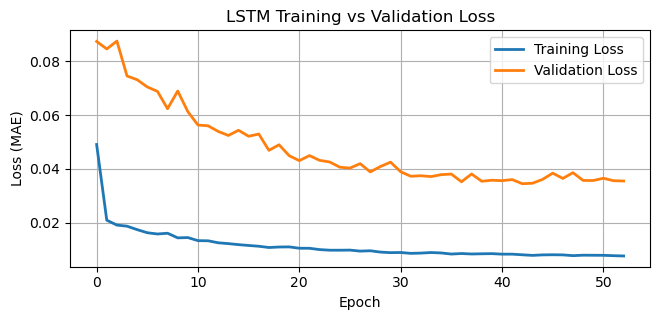

In [106]:
# === Step 7: Judgement of quality of fitting / Beurteilung der Modellgüte ===
# Training vs. Validation Loss plots / Training vs. Validierungsverlust
plt.figure(figsize=(6.7, 3.3))
plt.plot(history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 8 – Model Prediction and Evaluation, Saving the results

This step uses the trained LSTM model to generate predictions on the test set and compares them quantitatively with the actual values. The model's performance is evaluated using **Mean Absolute Error (MAE)** and the **R² score** as metrics on unseen test data.

To this aim, this step reverses the normalization and detrending applied earlier so that LSTM predictions can be directly compared with ARIMA and real closing prices:  
First, it determines whether the model was trained on linearly or exponentially detrended data or on differenced data, and computes the corresponding test segment.  
The predicted values are then **inverse-transformed** from normalized scale back to the detrended scale using the original `MinMaxScaler`.  
To fully recover the original price scale, the model’s predictions are **recombined with the trend or the actual closing level**, depending on the transformation method used.  

Finally, the re-transformed predictions are stored in a new CSV file (`lstm_preds_retransformed.csv`) for further comparison and integration into the ensemble forecasting pipeline.


### Schritt 8 – Modellvorhersage und Evaluation, Abspeichern

In diesem Schritt wird das trainierte LSTM-Modell verwendet, um Vorhersagen auf dem Testdatensatz zu erzeugen und diese quantitativ mit den tatsächlichen Werten zu vergleichen. Die Modellgüte wird anhand des **Mean Absolute Error (MAE)** und des **R²-Scores** auf den unbekannten Testdaten bewertet.

Zu diesem Zweck macht man die zuvor angewandte **Normalisierung und Enttrendung** rückgängig, sodass die LSTM-Vorhersagen direkt mit ARIMA und den tatsächlichen Schlusskursen verglichen werden können:  
Zunächst wird festgestellt, ob das Modell auf linear oder exponentiell enttrendeten Daten oder auf differenzierten Daten trainiert wurde, und der entsprechende Testabschnitt wird ermittelt.  
Die vorhergesagten Werte werden dann mithilfe des ursprünglichen `MinMaxScaler` **rücktransformiert**, d.h. aus der normalisierten Skala zurück in die enttrendete Skala überführt.  
Um die tatsächliche Preisskala vollständig wiederherzustellen, werden die Vorhersagen des Modells anschließend **wieder mit dem Trend bzw. dem tatsächlichen Kursniveau kombiniert**, je nach angewandter Vorverarbeitung.

Abschließend werden die rücktransformierten Vorhersagen in einer neuen CSV-Datei (`lstm_preds_retransformed.csv`) gespeichert, um sie im nächsten Schritt mit ARIMA zu vergleichen oder in das Ensemble-Modell zu integrieren.

In [109]:
# === STEP 8.A: Predict + retransform to original scale / Vorhersage + Rücktransformation zur originalen Skala ===
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
test_trend  = trend[val_end + number_of_delays :] if trend_used != "difference" else y_raw[val_end + number_of_delays :]

# Back-transform preditions to original scale (required for comparison with ARIMA pipeline and subsequent ensemble approach)
#Rücktransformation der Vorhersagen auf die ursprüngliche Skala (erforderlich für den Vergleich mit der ARIMA-Pipeline und die anschließende Ensemble-Methode)
y_pred_lstm_usd = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten() + test_trend
y_true_lstm = df["Close"].iloc[val_end + number_of_delays :].values

# Computation of the metrics / Bewertungsmetrikenberechnung
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm_usd)
r2_lstm   = r2_score(y_true_lstm, y_pred_lstm_usd)

print("\n Results for generalization to test data / Ergebnisse für Generalisierung auf Testdaten:")
print("\n MAE value for the LSTM network / MAE Wert für das LSTM Netz:")
print(f"  LSTM MAE : {mae_lstm:.4f} USD")
print("\n R² Score for the LSTM network / R² Wert für das LSTM Netz:")
print(f"  LSTM R²   : {r2_lstm:.4f}")

# === STEP 8.B: Save predictions / Speichere die Vorhersagen ===
lstm_re_df = pd.DataFrame(
    {"Date": df["Date"].iloc[val_end + number_of_delays : val_end + number_of_delays + len(y_pred_lstm_usd)], "LSTM": y_pred_lstm_usd}
)
lstm_re_df.to_csv("lstm_preds_retransformed.csv", index=False)
print("\n Saved LSTM predictions to 'lstm_preds_retransformed.csv'")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

 Results for generalization to test data / Ergebnisse für Generalisierung auf Testdaten:

 MAE value for the LSTM network / MAE Wert für das LSTM Netz:
  LSTM MAE : 1.0941 USD

 R² Score for the LSTM network / R² Wert für das LSTM Netz:
  LSTM R²   : 0.9877

 Saved LSTM predictions to 'lstm_preds_retransformed.csv'


### Step 9 – ARIMA Model Analysis

This block begins by using *pmdarima*'s `auto_arima` to determine the optimal ARIMA hyperparameters for the raw price series `y_raw`.  
The autoregressive orders *p* and moving average orders *q* are searched from $0$ to $5$, while `auto_arima` automatically determines the required degree of differencing *d* by minimizing an information criterion.  
Seasonality is explicitly turned off, as the series is modeled as non-seasonal, and the stepwise procedure accelerates the grid search.  
Warnings from non-invertible or non-stationary trial models are suppressed to keep the console output clean.  
After identifying the best $(p,d,q)$ triple, a `statsmodels` `ARIMA` instance is created and fitted to the entire pre-processed training set of the price series.  
The trained model then produces out-of-sample forecasts using `fitted.predict`, i.e., on a rolling window basis for each observed point.  
These predictions `y_pred_arima` retain the original time index, ensuring proper alignment.  
A new `DataFrame` stores each forecast alongside its corresponding `Date`, facilitating later merging.  
The table is saved as **`arima_preds.csv`** to disk so that subsequent notebook sections can compare ARIMA to LSTM and the ensemble.

#### Evaluating the ARIMA Fit

A truly meaningful assessment of forecast quality requires out-of-sample or rolling-origin validation. Below, we briefly summarize common strategies.

**1 Train/Test Split (fixed horizon)**  
Choose a single split date, fit the ARIMA model to all data before it, and forecast the remaining future block.  
This yields a single snapshot of the error. It is simple and quick, but highly dependent on the split location.  
Suitable when the series is long and (nearly) stationary, so the training set represents the future well.

**2 Rolling Forecast Origin (sliding window)**  
A fixed-width window shifts stepwise forward. In each position, the model is refit and the next *h* observations are forecasted.  
Older data drop out, emphasizing recent information and allowing for regime changes.  
This procedure is computationally intensive but mirrors real-world trading systems that store only recent history.

**3 Walk-Forward Validation (expanding window)**  
Start with an initial block, then append new data point by point, refit the model, and forecast.  
As the window grows, the model benefits from the full historical context. This is ideal if the data-generating process is stable.  
The resulting error series shows how forecast quality evolves with increasing evidence.

**4 Time-Series Cross-Validation (blocked *k-fold*)**  
The series is divided into *K* consecutive blocks; for block *k*, the model is trained on all preceding data and tested on that block—without ever peeking into the future.  
Repeat this for all blocks to obtain multiple independent error estimates without discarding large portions of the data.  
This is especially useful for hyperparameter tuning and model selection when observations are limited.

**Why do we restrict ourselves to out-of-sample forecasts on a rolling window basis?**  
This notebook reconstructs the methodology of the originally referenced publication. A rolling-window algorithm was initially attempted also for training the ARIMA model but this was computationally very expensive. Due to a lack of documentation, it is unclear what clean procedure the authors used to analyze the dataset with ARIMA. Therefore, we apply out-of-sample forecasts on a rolling window basis here, in order to proceed with implementing the ensemble approach later on.

### Schritt 9 - Analyse über das ARIMA Modell

Der Block startet mit *pmdarima* `auto_arima`, um die optimalen ARIMA-Hyperparameter für die Rohpreisreihe `y_raw` zu ermitteln.  
Dabei werden die autoregressiven Ordnungen *p* und die Moving-Average-Ordnungen *q* jeweils von $0$ bis $5$ durchsucht, während `auto_arima` den notwendigen Differenzierungsgrad *d* durch Minimierung eines Informationskriteriums bestimmt.  
Saisonalität wird bewusst deaktiviert, weil die Reihe als nicht saisonal modelliert wird, und das Step-wise-Verfahren beschleunigt die Rastersuche.  
Warnungen durch nicht invertierbare oder nicht stationäre Testmodelle werden unterdrückt, um die Konsolenausgabe übersichtlich zu halten.  
Nach Auffinden des besten Tripels `(p,d,q)` wird mit `statsmodels` eine `ARIMA`-Instanz erzeugt und auf das gesamte vorverarbeitete trainings set der Preisreihe gefittet.  
Das trainierte Modell erstellt anschließend mit `fitted.predict` out-of-Sample-Prognosen auf der Basis gleitender Fenster, also Ein-Schritt-Vorhersagen für jeden beobachteten Punkt.  
Diese Vorhersagen `y_pred_arima` behalten die ursprüngliche Zeitachse, sodass sie korrekt ausgerichtet sind.  
Ein neues `DataFrame` fasst jede Prognose zusammen mit dem zugehörigen `Date`, was späteres Zusammenführen erleichtert.  
Die Tabelle wird unter **`arima_preds.csv`** auf die Festplatte geschrieben, damit nachfolgende Notebook-Abschnitte ARIMA gegen LSTM und Ensemble auswerten können.  

#### Prüfung der Güte des ARIMA-Fits

Eine wirklich aussagekräftige Beurteilung der Prognosequalität erfordert Out-of-Sample- oder Rolling-Origin-Validierung. Nachfolgend fassen wir die gängigen Strategien kurz zusammen.

**1 Train/Test-Split (fester Horizont)**  
Man wählt ein einziges Schnittpunkt-Datum, fittet das ARIMA-Modell auf alle Daten davor und prognostiziert den verbleibenden Zukunftsblock.  
Das liefert einen einzigen Fehlerschnappschuss. Dies ist simpel und schnell, aber stark abhängig von der Lage des Splits.  
Geeignet, wenn die Reihe lang und (nahezu) stationär ist, sodass das Training die Zukunft repräsentiert.

**2 Rolling Forecast Origin (gleitendes Fenster)**  
Ein Fenster fester Breite verschiebt sich schrittweise nach vorn. In jeder Position wird das Modell neu gefittet und die nächsten *h* Beobachtungen werden prognostiziert.  
Ältere Daten fallen heraus, wodurch die Bewertung die jüngsten Informationen betont und auf Regimewechsel reagiert.  
Diese Prozedur ist rechenintensiv, spiegelt aber reale Handelssysteme, in denen nur der neueste Verlauf gespeichert wird.

**3 Walk-Forward-Validation (wachsendes Fenster)**  
Man startet mit einem Anfangsblock, fügt nach jedem neuen Punkt die frischen Daten dem Trainingssatz hinzu, fittet erneut und sagt voraus.  
Da das Fenster wächst, profitiert das Modell von der gesamten Historie. Dies ist ideal, wenn der Datengenerierungsprozess stabil ist.  
Die Fehlerreihe zeigt, wie sich die Prognosegüte mit zunehmender Evidenz entwickelt.

**4 Time-Series Cross-Validation (blockiertes *k-fold*)**  
Die Reihe wird in *K* aufeinanderfolgende Blöcke geteilt; für Block *k* trainiert man auf allen davorliegenden Daten und testet auf diesem Block, ohne je in die Zukunft zu schauen.  
Das wiederholt man für alle Blöcke und erhält mehrere unabhängige Fehlerschätzungen, ohne einen großen Datenanteil dauerhaft wegzuwerfen.  
Dies ist besonders nützlich für Hyperparametersuche und Modellauswahl, wenn die Beobachtungen begrenzt sind.

**Warum beschränken wir uns auf In-Sample-Prognosen?**  
Dieses Notebook rekonstruierte die Methode der eingangs erwähnten Publikation. Ein Rolling-Window-Algorithmus wurde für das Training des ARIMA-Modells zwar zunächst ausprobiert, was aber rechnerisch sehr teuer war. Mangels Dokumentation ist unklar, welchen sauberen Weg die Autoren zur Analyse des Datensatzes mit ARIMA einschlugen. Daher verwenden wir hier out-of-Sample-Prognosen auf der Basis gleitender Fenster, damit im weiteren Verlauf der Ensemble-Ansatz umgesetzt werden kann.

In [112]:
# === STEP 9: ARIMA model with identical preprocessing / ARIMA Modell mit identischer Vorverarbeitung der Daten ===

# Step 9.A: Perform grid search for best model then fit / Rastersuche nach bestem Modell dann fitten

print("\nARIMA grid-search on train_norm …")
arima_order = pm.auto_arima(
    train_norm,
    start_p=0,
    max_p=5,
    start_q=0,
    max_q=5,
    d=None,
    seasonal=False,
    stepwise=True,
    error_action="ignore",
    suppress_warnings=True,
).order
print(f"  → Selected order: {arima_order}")

model   = ARIMA(train_norm, order=arima_order)
results = model.fit()
print("Initial ARIMA model fit completed.")

# Step 9.B: ARIMA predictions on out-of-sample data in rolling window way / ARIMA Vorhersagen auf out-of-sample Daten in laufenden Fenstern
for z in val_norm:
    results = results.append([z], refit=False)

#number_of_delays = 90
first_pred_idx   = val_end + number_of_delays
preds_norm = []

for z in test_norm[:number_of_delays]:
    results = results.append([z], refit=False)

for z in test_norm[number_of_delays:]:
    preds_norm.append(results.forecast()[0])
    results = results.append([z], refit=False)

dates_pred = df["Date"].iloc[first_pred_idx:].reset_index(drop=True)
preds_usd  = scaler.inverse_transform(np.array(preds_norm).reshape(-1, 1)).flatten()

if trend_used != "difference":
    preds_usd += trend[first_pred_idx:]
else:
    preds_usd += y_raw[first_pred_idx:]

y_true_test = df["Close"].iloc[first_pred_idx:].values
mae_arima = mean_absolute_error(y_true_test, preds_usd)
r2_arima    = r2_score(y_true_test, preds_usd)

print("\n Results for out-of-sample testing/ Ergebnisse für out-of-sample Testen:")
print("\n MAE value for the ARIMA model / MAE Wert für das ARIMA Modell:")
print(f"  ARIMA MAE : {mae_arima:.4f} USD")
print("\n R² Score for the ARIMA model / R² Wert für das ARIMA Modell:")
print(f"  ARIMA R²   : {r2_arima:.4f}")

# Step 9.C: Save ARIMA predictions / Speichern der ARIMA Vorhersagen
arima_df = pd.DataFrame({"Date": dates_pred, "ARIMA": preds_usd})
arima_df.to_csv("arima_preds.csv", index=False)
print("Saved ARIMA predictions to: / ARIMA Vorhersagen gespeichert unter: 'arima_preds.csv'")


ARIMA grid-search on train_norm …
  → Selected order: (3, 1, 3)
Initial ARIMA model fit completed.

 Results for out-of-sample testing/ Ergebnisse für out-of-sample Testen:

 MAE value for the ARIMA model / MAE Wert für das ARIMA Modell:
  ARIMA MAE : 0.9736 USD

 R² Score for the ARIMA model / R² Wert für das ARIMA Modell:
  ARIMA R²   : 0.9914
Saved ARIMA predictions to: / ARIMA Vorhersagen gespeichert unter: 'arima_preds.csv'


### Step 10 - Bringing all predictions together

The code reloads the raw Nike closing-price data, drops any remaining NaNs, reorders the rows chronologically, and linearly interpolates to ensure a continuous series.  
It then reads the two CSV files that store the retransformed LSTM forecasts and the ARIMA forecasts, each keyed by the same `Date` column.  
An inner join on `Date` first fuses the ARIMA and LSTM data frames so that only timestamps present in both prediction sets are retained.  
A second inner join with the cleaned ground-truth prices produces `merged`, a single table that contains actual closes alongside both models’ predictions for the exact same dates.  

### Schritt 10 - Zusammenbringen aller Vorhersagen

Der Code lädt die ursprünglichen Nike-Schlusskursdaten erneut, entfernt verbliebene NaNs, sortiert sie chronologisch und füllt Lücken per linearer Interpolation auf, sodass eine durchgehende Zeitreihe entsteht.  
Anschließend werden die beiden CSV-Dateien mit den rücktransformierten LSTM-Prognosen und den ARIMA-Vorhersagen eingelesen, die jeweils eine `Date`-Spalte besitzen.  
Mittels innerem Join auf `Date` werden zunächst die ARIMA- und LSTM-DataFrames verknüpft, sodass nur Zeitpunkte erhalten bleiben, für die beide Modelle Schätzwerte liefern.  
Ein zweiter innerer Join mit den bereinigten Ist-Preisen erzeugt `merged`, eine einheitliche Tabelle, die die tatsächlichen Kurse und beide Modellprognosen für exakt dieselben Datenpunkte enthält.  

In [115]:
# === STEP 10: Merge all predictions and the empirical data/ Vereinigung aller Vorhersagen und die empirischen Daten ===
nke_df = pd.read_csv("NKE.csv", parse_dates=["Date"])[["Date", "Close"]]
nke_df = nke_df.dropna().sort_values("Date")
nke_df["Close"] = nke_df["Close"].interpolate(method="linear")

lstm_df  = pd.read_csv("lstm_preds_retransformed.csv", parse_dates=["Date"])
arima_df = pd.read_csv("arima_preds.csv",           parse_dates=["Date"])

merged = pd.merge(arima_df, lstm_df, on="Date", how="inner")
merged = pd.merge(merged, nke_df, on="Date", how="inner")

### Step 11 - Ensemble approach

The single line computes `Ensemble` by taking the arithmetic mean of the LSTM and ARIMA predictions for every timestamp, i.e. assigning each model a $50 \%$ weight.  
Even this naïve average can meaningfully cut error because it harnesses **diversification**: the two models make different mistakes, so their unbiased noises partly cancel, reducing forecast variance.  
Here the LSTM specialises in capturing nonlinear, long-range dependencies, while the ARIMA covers linear, short-memory structure, giving negatively correlated residuals that blend well.  
With no extra parameters to tune, the equal-weight ensemble is computationally free and often outperforms more complex weighting schemes unless you have a very large validation set to estimate optimal weights.  


### Schritt 11 - Ensemble-Ansatz

Die einzelne Zeile berechnet `Ensemble`, indem sie den arithmetischen Mittelwert der LSTM- und ARIMA-Vorhersagen für jeden Zeitstempel bildet, also beiden Modellen ein Gewicht von $50\,\%$ zuweist.  
Selbst dieser naive Durchschnitt kann den Fehler deutlich verringern, weil er **Diversifikation** nutzt: Die beiden Modelle machen unterschiedliche Fehler, deren unbeeinflusste Störanteile sich teilweise gegenseitig aufheben und so die Prognosevarianz reduzieren.  
Hier erfasst das LSTM nichtlineare Langzeitabhängigkeiten, während das ARIMA lineare Kurzzeitstrukturen modelliert. Folglich sind ihre Residuen oft negativ korreliert und ergänzen sich gut.  
Ohne weitere Hyperparameter ist das gleichgewichtete Ensemble praktisch kostenlos in der Berechnung und schlägt häufig komplexere Gewichtungsmethoden, sofern nicht eine sehr große Validierungsmenge zur Schätzung optimaler Gewichte verfügbar ist.  

In [118]:
# === STEP 11: Construction of the Ensemble / Konstruktion des Ensembles ===
merged["Ensemble"] = (merged["LSTM"] + merged["ARIMA"]) / 2

### Step 12 - Evaluation of all models

This block extracts the ground-truth closing prices, computes Mean Absolute Error (MAE) and coefficient of determination ($R^{2}$) for the LSTM, ARIMA, and ensemble predictions, and stores each metric in clearly named variables.  
By printing the results side-by-side, it offers an immediate quantitative comparison of point-forecast accuracy (MAE in USD) and explained variance ($R^{2}$) across the three models.  
The output reveals at a glance which model delivers the lowest average error and the highest share of variance explained, guiding subsequent model selection or refinement. 

### Step 13 + 14 – Forecast Plots and Saving Results

This section generates a line plot overlaying the actual Nike closing prices with the predictions from the LSTM model, the ARIMA model, and their equally weighted ensemble.

After visual inspection, the script exports the complete `merged` DataFrame (containing date, actual prices, and all forecasts) as **`merged_model_predictions.csv`**, enabling further analyses or external reporting.


### Schritt 12 – Bewertung aller Modelle

Dieser Block extrahiert die tatsächlichen Schlusskurse, berechnet den Mean Absolute Error (MAE) sowie den Bestimmtheitskoeffizienten ($R^{2}$) für die LSTM-, ARIMA- und Ensemble-Prognosen und speichert jede Kennzahl in klar benannten Variablen.  
Durch die nebeneinander gestellte Ausgabe erhält man sofort einen quantitativen Vergleich der Punktprognosegenauigkeit (MAE in USD) und der erklärten Varianz ($R^{2}$) über die drei Modelle hinweg.  
Das Ergebnis zeigt auf einen Blick, welches Modell den geringsten durchschnittlichen Fehler und den höchsten Anteil erklärter Varianz liefert und dient so als Entscheidungshilfe für die weitere Modellauswahl oder -verfeinerung.

### Schritt 13 + 14 – Diagramme der Prognosen und Speichern der Ergebnisse

Dieser Abschnitt erstellt ein Liniendiagramm, das die tatsächlichen Nike-Schlusskurse zusammen mit den Prognosen des LSTM-, des ARIMA-Modells und ihres gleichgewichteten Ensembles überlagert.

Nach der visuellen Prüfung exportiert das Skript das vollständige `merged`-DataFrame (mit Datum, Ist-Preisen und allen Prognosen) als **`merged_model_predictions.csv`**, um weitere Analysen oder externe Berichte zu ermöglichen.  


 MAE comparison:
  LSTM     : 1.0941 USD
  ARIMA    : 0.9736 USD
  Ensemble : 1.0033 USD

 R² comparison:
  LSTM     : 0.9877
  ARIMA    : 0.9914
  Ensemble : 0.9907


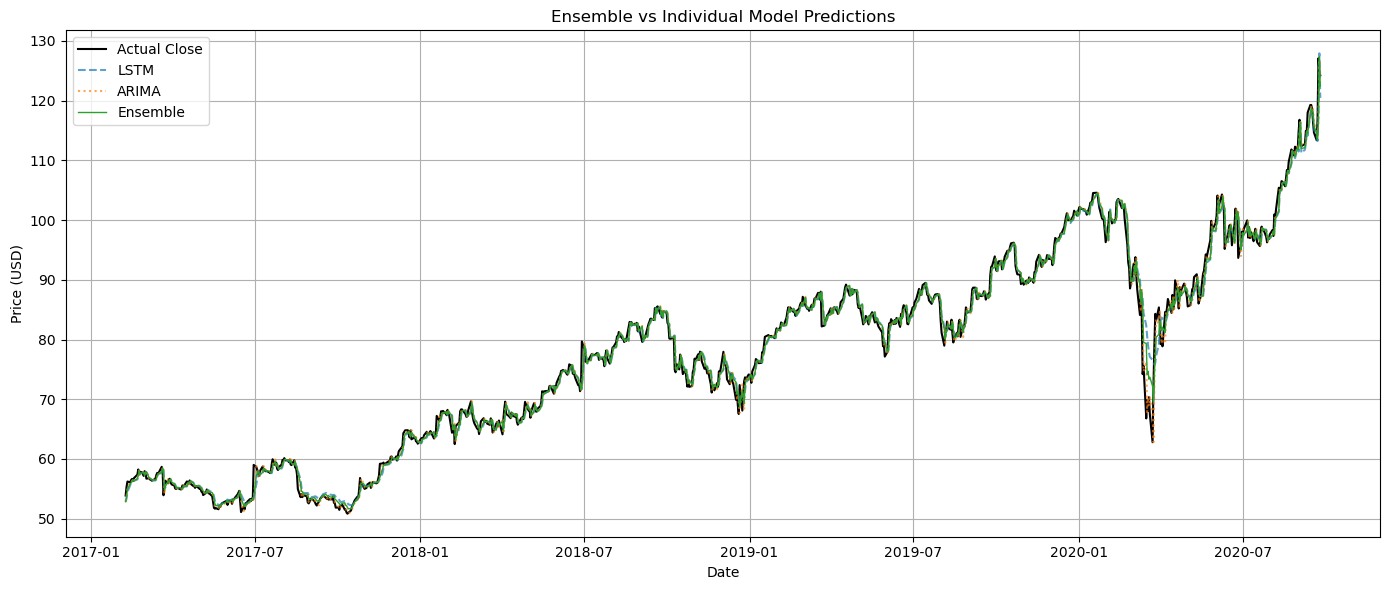

Saved merged predictions to 'merged_model_predictions.csv'


In [121]:
# === STEP 12: Evaluate all models via MAE and R²/ Bwertung aller Modelle via MAE und R²===
y_true       = merged["Close"]
mae_lstm    = mean_absolute_error(y_true, merged["LSTM"])
mae_arima   = mean_absolute_error(y_true, merged["ARIMA"])
mae_ensemble = mean_absolute_error(y_true, merged["Ensemble"])

r2_lstm      = r2_score(y_true, merged["LSTM"])
r2_arima     = r2_score(y_true, merged["ARIMA"])
r2_ensemble  = r2_score(y_true, merged["Ensemble"])

print("\n MAE comparison:")
print(f"  LSTM     : {mae_lstm:.4f} USD")
print(f"  ARIMA    : {mae_arima:.4f} USD")
print(f"  Ensemble : {mae_ensemble:.4f} USD")

print("\n R² comparison:")
print(f"  LSTM     : {r2_lstm:.4f}")
print(f"  ARIMA    : {r2_arima:.4f}")
print(f"  Ensemble : {r2_ensemble:.4f}")


# === STEP 13: Plot predictions  / Graphische Darstellungen aller Vorhersagen vs. empirische Daten===
plt.figure(figsize=(14, 6))
plt.plot(merged["Date"], merged["Close"],   label="Actual Close", color="black")
plt.plot(merged["Date"], merged["LSTM"],    label="LSTM",  linestyle="--", alpha=0.7)
plt.plot(merged["Date"], merged["ARIMA"],   label="ARIMA", linestyle=":",  alpha=0.7)
plt.plot(merged["Date"], merged["Ensemble"], label="Ensemble", linewidth=1.0)
plt.title("Ensemble vs Individual Model Predictions")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === STEP 14: Export merged predictions / Speicherung der vereinten Vorhersagen ===
merged.to_csv("merged_model_predictions.csv", index=False)
print("Saved merged predictions to 'merged_model_predictions.csv'")

### Step 15 - Comprehensive residual analysis

### Residual Plots

This block visualizes the prediction errors – residuals – of the LSTM, ARIMA, and ensemble models by subtracting each forecast from the actual closing price. A separate scatter plot is created for each model, all sharing the same y-axis range of ±0.5 USD. This uniform scaling enables direct comparison of deviations.  
A horizontal dashed line at zero marks perfect predictions, so points above or below indicate over- or underestimation on individual days.  
The focus is on detecting systematic patterns such as volatility clustering or bias drifts, which may indicate model misspecification.  
By comparing the three plots side by side, one should be able to quickly assess which residual cloud is most tightly centered around zero and whether the ensemble effectively compensates for individual model errors.

### Simple statistics of the residuals

This block quantifies the residual behaviour of each model by first computing the mean (bias) and standard deviation (dispersion) of the LSTM, ARIMA, and ensemble errors.  
Assuming approximate normality, it then constructs symmetric $95 \%$ confidence bands $(± 1.96 × σ)$ around zero for every residual set.  
For each model, the script counts how many individual residuals fall inside these bounds and expresses the result as a percentage of the total.  
If the residuals are well-behaved white noise, roughly $95 \%$ should lie within the interval. Substantial departures hint at fat tails, heteroscedasticity (non-constancy of the standard deviation of the errors), or misspecification.  
The printed summary lets you compare bias, volatility, and coverage across models in a compact, numeric form without relying solely on visual plots.  
Overall, it reveals whether the ensemble not only lowers average error but also tightens the residual distribution relative to its single-model components.

### Histrograms of the residuals

The code computes residuals for LSTM, ARIMA, and the ensemble, then derives each set’s mean and standard deviation to parameterise a reference normal distribution.  
For every model it draws a $40$-bin histogram with kernel-density estimate, providing an empirical view of how residuals are distributed.  
A dashed black curve overlays the theoretical normal PDF using the same $\mu$ and $\sigma$, enabling a quick visual normality check.  
Red vertical lines mark the $\pm1.96\,\sigma$ limits, highlighting the $95$ % confidence interval where well-behaved white-noise errors should mostly fall.  
Running the identical routine three times lets you compare skewness, kurtosis and overall spread across models in a consistent format.  
If the ensemble histogram is narrower and aligns better with the normal curve than the individual ones, it suggests the averaging step has reduced variance and heavy-tail risk.

### Detailed Residual Diagnostics

The following code block performs an in-depth residual analysis for the LSTM, ARIMA, and ensemble models. First, each residual vector is recomputed by subtracting the model prediction from the observed closing price.  

Next, a three-part plot is generated containing the ACF, PACF, and Q–Q plot:

The **Autocorrelation Function (ACF)** plot shows the linear correlation of residuals with their own past values up to lag 40 and reveals remaining serial dependencies.

The **Partial Autocorrelation Function (PACF)** filters out the influence of shorter lags, so each bar reflects the direct correlation at lag *k*, exposing any unmodeled AR structure. Ideally, all bars in ACF and PACF remain within the $95\%$ confidence bounds, indicating residual white noise.

The **Quantile–Quantile Plot (Q–Q plot)** overlays empirical residual quantiles on a theoretical normal line and reveals skewness, heavy tails, or outliers.

After the plots, the script runs three formal hypothesis tests:

The **Ljung–Box Portmanteau Test** checks for autocorrelations across multiple lags under the null hypothesis of independent residuals. A high $p$-value supports model adequacy. A low Ljung–Box $p$-value indicates remaining serial correlation and suggests increasing the ARIMA order or adding lags to the neural network.

The **Shapiro–Wilk Test** assesses the null hypothesis that the residuals follow a normal distribution, which is important if confidence intervals assume Gaussian errors. A result of $p < 0.05$ indicates deviation from normality, suggesting heavy tails or skewness and potentially necessitating more robust error models.

The **Wilcoxon Signed-Rank Test** is a nonparametric test for whether the median of the residuals is zero. It protects against systematic bias even when the mean error is small. Rejection of the Wilcoxon null suggests persistent over- or underestimation that should be addressed.

Together, these plots and tests provide a comprehensive judgment on serial independence, normality, and bias, and assess whether each model's residuals meet the assumptions of reliable statistical forecasting.


### Schritt 15 - Umfassende Analyse der Residuen

### Residuen-Diagramme

Dieser Block stellt die Prognosefehler – Residuen – der LSTM-, ARIMA- und Ensemble-Modelle dar, indem jede Vorhersage vom tatsächlichen Schlusskurs abgezogen wird. Für jedes Modell wird ein eigenes Streudiagramm erzeugt, alle teilen sich dieselbe y-Achse von ± 0,5 USD. Diese einheitliche Skalierung macht Abweichungen direkt vergleichbar.  
Eine horizontale gestrichelte Linie bei Null kennzeichnet perfekte Prognosen, sodass Punkte darüber bzw. darunter Über- oder Unterschätzungen an einzelnen Tagen anzeigen.  
Der Fokus liegt insgesamt auf systematischen Mustern wie Volatilitätsclustern oder Bias-Drifts, die auf Modellfehlspezifikation hindeuten könnten.  
Durch den Nebeneinandervergleich der drei Diagramme sollte sich idealerweise schnell erkennen lassen, wessen Residuenwolke am engsten um Null zentriert ist und ob das Ensemble individuelle Fehler wirksam ausgleicht.

### Einfache Statistik der Residuen

Dieser Block quantifiziert das Residuenverhalten jedes Modells, indem zunächst Mittelwert (Bias) und Standardabweichung (Streuung) der Fehler von LSTM, ARIMA und Ensemble berechnet werden.  
Unter Annahme näherungsweiser Normalverteilung werden anschließend symmetrische $95\,\%$-Konfidenzbänder $(\pm 1{,}96 \times \sigma)$ um Null für jedes Residuenset konstruiert.  
Für jedes Modell ermittelt das Skript, wie viele einzelne Residuen innerhalb dieser Grenzen liegen und gibt das Ergebnis als Prozentsatz der Gesamtanzahl aus.  
Liegt der Residuenprozess tatsächlich als weißes Rauschen vor, sollten rund $95\,\%$ der Werte innerhalb des Intervalls liegen. Deutliche Abweichungen deuten auf fette Tails, Heteroskedastizität (Nichtkonstanz der Standardabweichung der Fehler) oder Fehlspezifikation hin.  
Die Ausgabe erlaubt es, Bias, Volatilität und Abdeckungsgrad der Modelle kompakt numerisch zu vergleichen, ohne sich allein auf graphische Darstellungen zu stützen.  
Insgesamt zeigt sie, ob das Ensemble nicht nur den durchschnittlichen Fehler reduziert, sondern auch die Residuenverteilung gegenüber den Einzelmodellen strafft.  

### Histogramme der Residuen

Der Codeblock berechnet die Residuen für LSTM, ARIMA und das Ensemble und ermittelt anschließend für jedes Set Mittelwert und Standardabweichung, um eine Referenz-Normalverteilung zu parametrisieren.  
Für jedes Modell wird ein Histogramm mit $40$ Klassen inklusive Kernel-Density-Schätzung erzeugt, was einen empirischen Einblick in die Verteilung der Residuen liefert.  
Eine schwarze gestrichelte Kurve legt die theoretische Normalverteilungsdichte mit denselben $\mu$ und $\sigma$ darüber und erlaubt so eine schnelle visuelle Normalitätsprüfung.  
Rote vertikale Linien markieren die $\pm1{,}96\,\sigma$-Grenzen und heben das $95$-%-Konfidenzintervall hervor, in dem sich gutartiges Weißes Rauschen überwiegend befinden sollte.  
Durch das dreimalige Ausführen derselben Routine lassen sich Schiefe, Kurtosis (Wölben) und Gesamtstreuung der Modelle in einheitlichem Format vergleichen.  
Ist das Ensemble-Histogramm schmaler und deckt sich besser mit der Normalkurve als die einzelnen, deutet das darauf hin, dass das Mittelungsverfahren Varianz und Fat-Tail-Risiko verringert hat.  

### Detaillierte Residuendiagnose

Der folgende Codeblock führt eine gründliche Residuenanalyse für die LSTM-, ARIMA- und Ensemble-Modelle durch. Zunächst wird jeder Residuenvektor neu berechnet, indem der beobachtete Schlusskurs von der jeweiligen Modellprognose abgezogen wird.  

Anschließend wird eine dreigeteilte Grafik erstellt, die ACF-, PACF- und Q-Q-Plot enthält: 

Der **Autokorrelationsfunktions-Plot (ACF)** zeigt die lineare Korrelation der Residuen mit ihren eigenen Vergangenheitswerten bis Lag 40 und deckt verbliebene serielle Abhängigkeiten auf.  

Die **Partielle Autokorrelationsfunktion (PACF)** blendet Einflüsse kürzerer Lags aus, sodass jeder Balken die direkte Korrelation bei Lag *k* darstellt und unmodellierte AR-Struktur sichtbar macht. Im Idealfall bleiben alle Balken von ACF und PACF innerhalb der $95\%$-Konfidenzgrenzen, was auf weißes Rauschen der Residuen hindeutet.  

Der **Quantil-Quantil-Plot (Q-Q-Plot)** legt empirische Residuenquantile über eine theoretische Normallinie und deckt Schiefe, fette Tails oder Ausreißer auf.

Nach den Grafiken führt das Skript drei formale Hypothesentests durch:

Der **Ljung-Box-Portmanteau-Test** prüft Autokorrelationen über mehrere Lags gemeinsam unter der Nullhypothese unabhängiger Residuen. Ein hoher $p$-Wert spricht für Modelladäquatheit. Ein niedriger Ljung-Box-$p$-Wert signalisiert verbleibende serielle Korrelation und legt nahe, die ARIMA-Ordnung zu erhöhen oder dem neuronalen Netz weitere Lags zu geben.

Der **Shapiro-Wilk-Test** testet die Nullhypothese normal verteilter Residuen, was wichtig ist, wenn Konfidenzintervalle auf Gaußschen Fehlern beruhen. Ergibt Shapiro-Wilk ein $p < 0,05$, weicht die Residuenverteilung von der Normalität ab. Das deutet auf fette Tails oder Schiefe hin und kann robustere Fehlermodelle erfordern.  

Der **Wilcoxon-Vorzeichenrang-Test** ist ein nichtparametrischer Test darauf, ob der Median der Residuen Null ist. Er schützt vor systematischem Bias selbst bei kleinem mittlerem Fehler. Wird die Wilcoxon-Null verworfen, deutet dies auf anhaltende Über- oder Unterschätzungen hin, die behoben werden sollten.  

In der Summe liefern diese Plots und Tests ein umfassendes Urteil über Serienunabhängigkeit, Normalität und Bias und prüfen, ob die Residuen jedes Modells die Annahmen verlässlicher statistischer Prognosen erfüllen.  

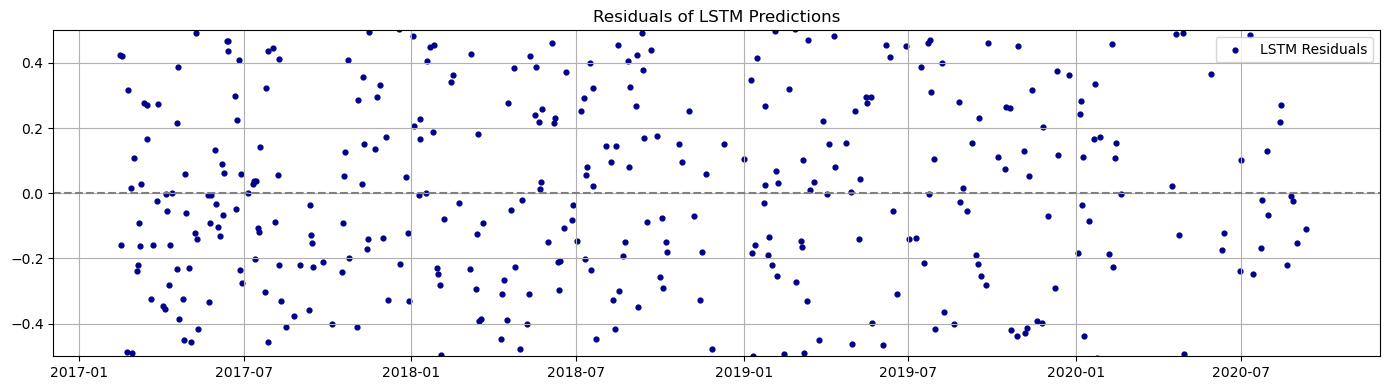

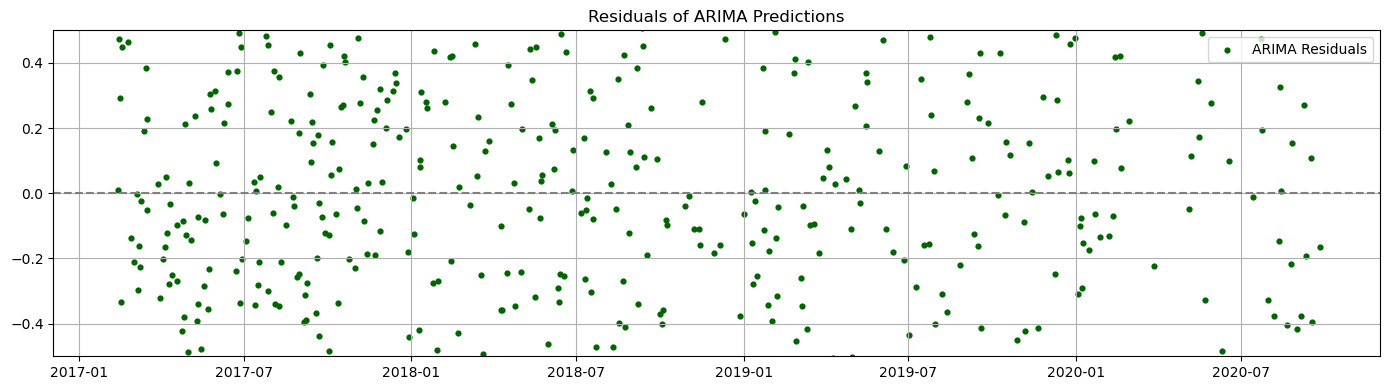

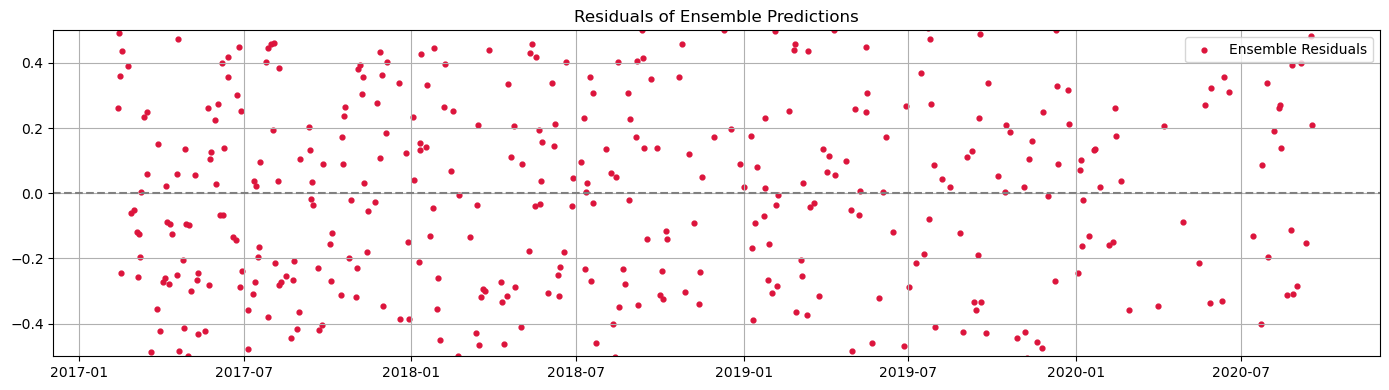


Naive LSTM Residual Analysis / Naive Residuenanalyse des LSTM-Modells:
  Mean of residuals / Mittelwerte der Residuen : μ= -0.0198
  Std. deviation of residuals / Standardabweichung der Residuen: σ= 1.8213
  95% confidence interval bounds : [-3.5698, 3.5698]
  881 out of 915 residuals (96.28%) within 95% confidence interval.

Naive ARIMA Residual Analysis / Naive Residuenanalyse des ARIMA-Modells:
  Mean of residuals / Mittelwerte der Residuen : μ= 0.0326
  Std. deviation of residuals / Standardabweichung der Residuen: σ= 1.5215
  95% confidence interval bounds : [-2.9822, 2.9822]
  870 out of 915 residuals (95.08%) within 95% confidence interval.

Naive Ensemble Residual Analysis / Naive Residuenanalyse des Ensemble-Modells:
  Mean of residuals / Mittelwerte der Residuen : μ= 0.0064
  Std. deviation of residuals / Standardabweichung der Residuen: σ= 1.5825
  95% confidence interval bounds : [-3.1016, 3.1016]
  869 out of 915 residuals (94.97%) within 95% confidence interval.


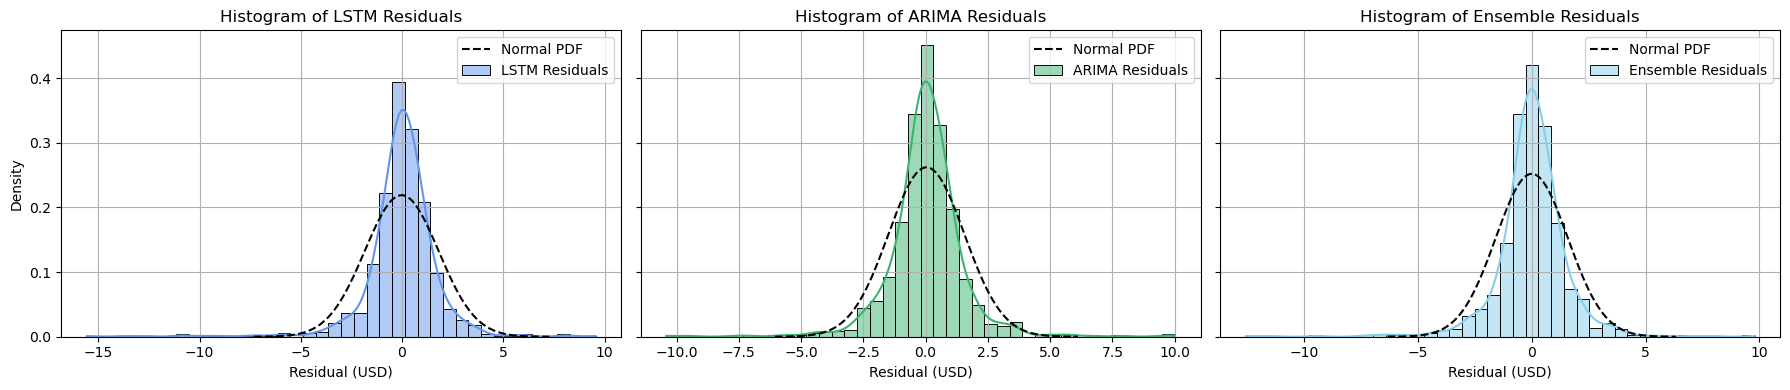

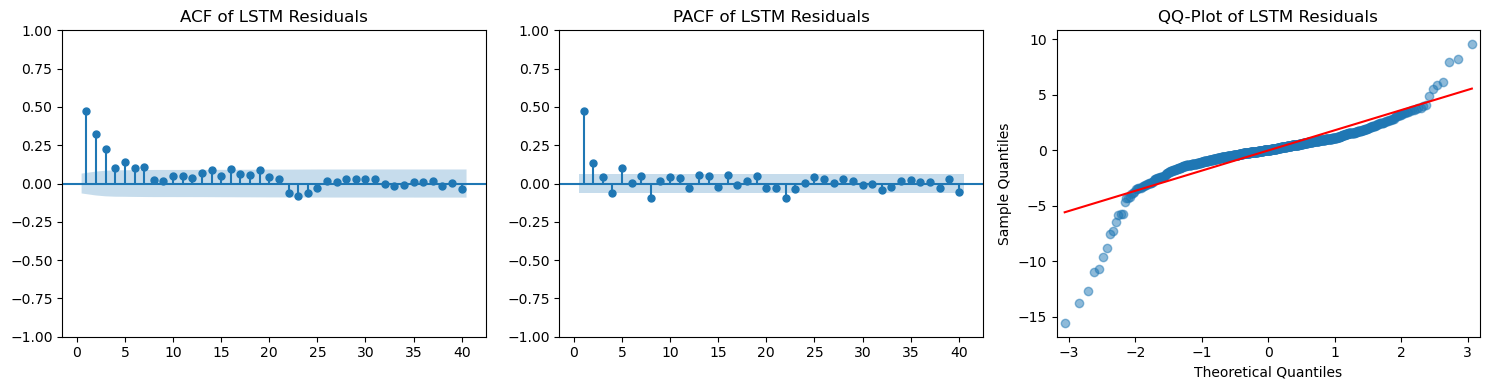


Ljung-Box test (LSTM residuals):
       lb_stat     lb_pvalue
10  403.245545  1.918439e-80
20  444.695804  1.039745e-81
30  461.853157  7.675754e-79
40  465.189258  7.990350e-74
→ Reject H₀: residuals exhibit significant autocorrelation.

Shapiro-Wilk test (LSTM residuals):
W = 0.7999, p = 0.0000
→ Reject H₀: residuals are **not** normally distributed.

Wilcoxon signed-rank test (median = 0, LSTM residuals):
W = 197698.0000, p = 0.1388
→ Fail to reject H₀: median of residuals does not differ from 0.


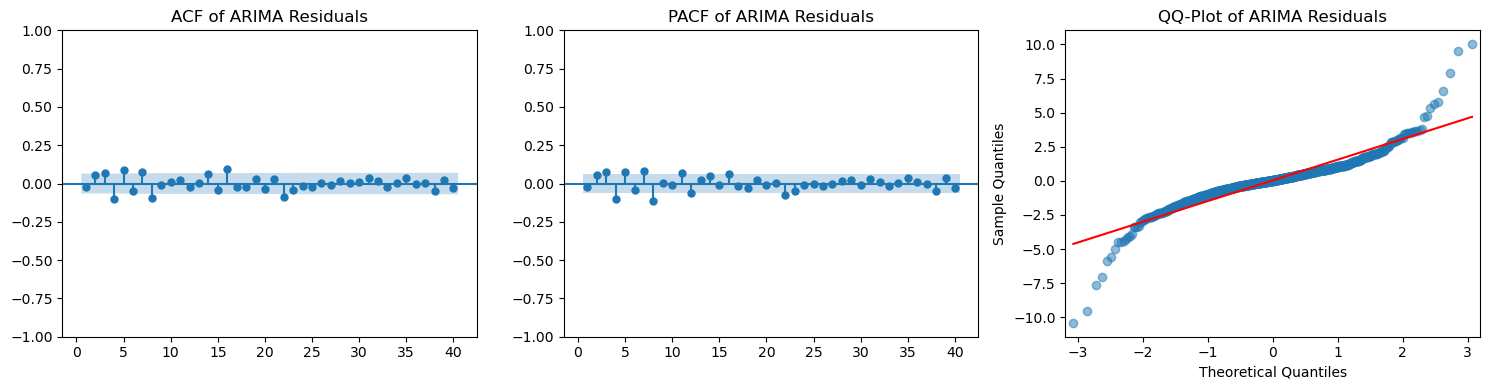


Ljung-Box test (ARIMA residuals):
      lb_stat  lb_pvalue
10  40.756458   0.000012
20  58.314140   0.000013
30  68.992396   0.000066
40  75.616118   0.000566
→ Reject H₀: residuals exhibit significant autocorrelation.

Shapiro-Wilk test (ARIMA residuals):
W = 0.8728, p = 0.0000
→ Reject H₀: residuals are **not** normally distributed.

Wilcoxon signed-rank test (median = 0, ARIMA residuals):
W = 200206.0000, p = 0.2434
→ Fail to reject H₀: median of residuals does not differ from 0.


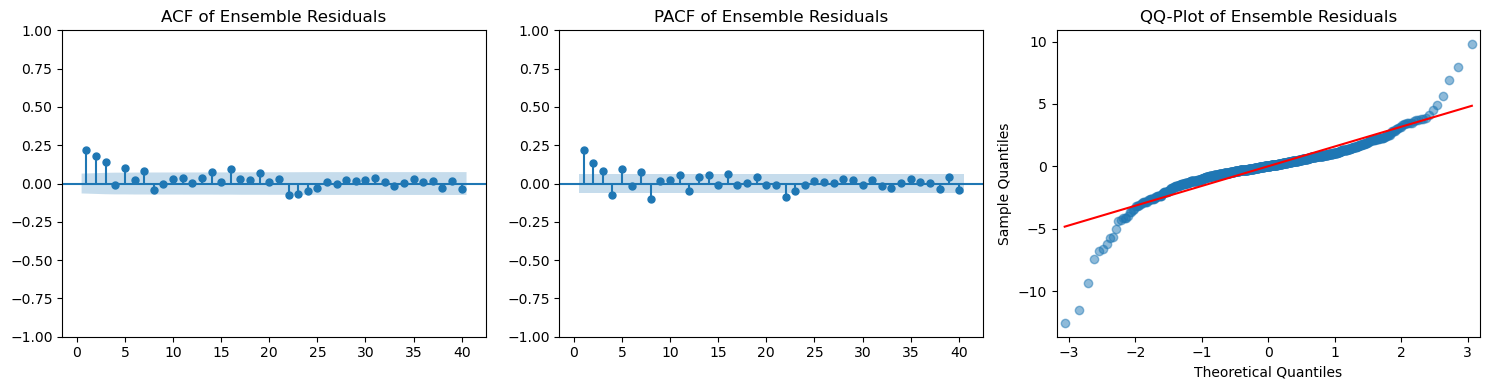


Ljung-Box test (Ensemble residuals):
       lb_stat     lb_pvalue
10  110.874122  3.555278e-19
20  133.310535  9.302462e-19
30  148.053456  1.482711e-17
40  152.735866  4.424786e-15
→ Reject H₀: residuals show significant autocorrelation (poor whiteness).

Shapiro-Wilk test (Ensemble residuals):
W = 0.8587, p = 0.0000
→ Reject H₀: residuals deviate from normality.

Wilcoxon signed-rank test (median = 0, Ensemble residuals):
W = 199664.0000, p = 0.2170
→ Fail to reject H₀: residuals are centred around zero (no bias detected).


In [124]:
# === STEP 15: Residual analysis & diagnostics ===
# Compute residuals / Berechnung der Residuen
lstm_residuals      = merged["Close"] - merged["LSTM"]
arima_residuals     = merged["Close"] - merged["ARIMA"]
ensemble_residuals  = merged["Close"] - merged["Ensemble"]

# --- Scatter plots of the residuals / Plots der Residuen ---
plt.figure(figsize=(14, 4))
plt.scatter(merged["Date"], lstm_residuals, color="darkblue", s=12, label="LSTM Residuals")
plt.axhline(0, linestyle="--", color="gray")
plt.ylim(-0.5, 0.5)
plt.title("Residuals of LSTM Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.scatter(merged["Date"], arima_residuals, color="darkgreen", s=12, label="ARIMA Residuals")
plt.axhline(0, linestyle="--", color="gray")
plt.ylim(-0.5, 0.5)
plt.title("Residuals of ARIMA Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.scatter(merged["Date"], ensemble_residuals, color="crimson", s=12, label="Ensemble Residuals")
plt.axhline(0, linestyle="--", color="gray")
plt.ylim(-0.5, 0.5)
plt.title("Residuals of Ensemble Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Naive residual statistics (LSTM,ARIMA and Ensemble) / Naive Statistik der Residuen ---
#LSTM
# Mean and Standard deviation / Mittelwert und Standardabweichung
mean_lstm_resid = lstm_residuals.mean()
std_lstm_resid  = lstm_residuals.std()
# 95% confidence interval bounds / 95% Konfidenzinterval um 0
lstm_lower, lstm_upper = -1.96 * std_lstm_resid, 1.96 * std_lstm_resid
# Count how many residuals fall within bounds / Zählung wieviele innerhalb des Intervalls sind
lstm_within = ((lstm_residuals >= lstm_lower) & (lstm_residuals <= lstm_upper)).sum()
lstm_total = len(lstm_residuals)
lstm_pct = lstm_within / lstm_total * 100
# Output
print("\nNaive LSTM Residual Analysis / Naive Residuenanalyse des LSTM-Modells:")
print(f"  Mean of residuals / Mittelwerte der Residuen : μ= {mean_lstm_resid:.4f}")
print(f"  Std. deviation of residuals / Standardabweichung der Residuen: σ= {std_lstm_resid:.4f}")
print(f"  95% confidence interval bounds : [{lstm_lower:.4f}, {lstm_upper:.4f}]")
print(f"  {lstm_within} out of {lstm_total} residuals ({lstm_pct:.2f}%) within 95% confidence interval.")

#ARIMA
# Mean and Standard deviation / Mittelwert und Standardabweichung
mean_arima_resid = arima_residuals.mean()
std_arima_resid  = arima_residuals.std()
# 95% confidence interval bounds / 95% Konfidenzinterval um 0
arima_lower, arima_upper = -1.96 * std_arima_resid, 1.96 * std_arima_resid
# Count how many residuals fall within bounds / Zählung wieviele innerhalb des Intervalls sind
arima_within = ((arima_residuals >= arima_lower) & (arima_residuals <= arima_upper)).sum()
arima_total = len(arima_residuals)
arima_pct = arima_within / arima_total * 100
# Output
print("\nNaive ARIMA Residual Analysis / Naive Residuenanalyse des ARIMA-Modells:")
print(f"  Mean of residuals / Mittelwerte der Residuen : μ= {mean_arima_resid:.4f}")
print(f"  Std. deviation of residuals / Standardabweichung der Residuen: σ= {std_arima_resid:.4f}")
print(f"  95% confidence interval bounds : [{arima_lower:.4f}, {arima_upper:.4f}]")
print(f"  {arima_within} out of {arima_total} residuals ({arima_pct:.2f}%) within 95% confidence interval.")

#Ensemble
# Mean and Standard deviation / Mittelwert und Standardabweichung
mean_ens_resid = ensemble_residuals.mean()
std_ens_resid  = ensemble_residuals.std()
# 95% confidence interval bounds / 95% Konfidenzinterval um 0
ens_lower, ens_upper = -1.96 * std_ens_resid, 1.96 * std_ens_resid
# Count how many residuals fall within bounds / Zählung wieviele innerhalb des Intervalls sind
ens_within = ((ensemble_residuals >= ens_lower) & (ensemble_residuals <= ens_upper)).sum()
ens_total = len(ensemble_residuals)
ens_pct = ens_within / ens_total * 100
# Output
print("\nNaive Ensemble Residual Analysis / Naive Residuenanalyse des Ensemble-Modells:")
print(f"  Mean of residuals / Mittelwerte der Residuen : μ= {mean_ens_resid:.4f}")
print(f"  Std. deviation of residuals / Standardabweichung der Residuen: σ= {std_ens_resid:.4f}")
print(f"  95% confidence interval bounds : [{ens_lower:.4f}, {ens_upper:.4f}]")
print(f"  {ens_within} out of {ens_total} residuals ({ens_pct:.2f}%) within 95% confidence interval.")

# --- Histograms of the residuals / Histogramme der Residuen---
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
for ax, res, col, title in zip(
    axes,
    [lstm_residuals, arima_residuals, ensemble_residuals],
    ["cornflowerblue", "mediumseagreen", "skyblue"],
    ["LSTM", "ARIMA", "Ensemble"],
):
    sns.histplot(res, bins=40, kde=True, stat="density", color=col, ax=ax, label=f"{title} Residuals")
    mu, sd = res.mean(), res.std()
    x_vals = np.linspace(mu - 4 * sd, mu + 4 * sd, 200)
    ax.plot(x_vals, norm.pdf(x_vals, mu, sd), linestyle="--", color="black", label="Normal PDF")
    ax.set_title(f"Histogram of {title} Residuals")
    ax.set_xlabel("Residual (USD)")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

# --- ACF / PACF / QQ for LSTM ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# ACF (autocorrelation function)
plot_acf(lstm_residuals, lags=40, zero=False, alpha=0.05, ax=axes[0])
axes[0].set_title("ACF of LSTM Residuals")
# PACF (partial autocorrelation function)
plot_pacf(lstm_residuals, lags=40, zero=False, alpha=0.05, method="ywm", ax=axes[1])
axes[1].set_title("PACF of LSTM Residuals")
# QQ-Plot
sm.qqplot(lstm_residuals, line="s", alpha=0.5, ax=axes[2])
axes[2].set_title("QQ-Plot of LSTM Residuals")
plt.tight_layout(); plt.show()

# ------------------------------ Ljung-Box --------------------------------------
print("\nLjung-Box test (LSTM residuals):")
lb_df = acorr_ljungbox(lstm_residuals, lags=[10, 20, 30, 40], return_df=True)
print(lb_df)
if lb_df["lb_pvalue"].iloc[-1] < 0.05:
    print("→ Reject H₀: residuals exhibit significant autocorrelation.")
else:
    print("→ Fail to reject H₀: residuals are indistinguishable from white noise.")

# ------------------------------ Shapiro-Wilk -----------------------------------
print("\nShapiro-Wilk test (LSTM residuals):")
W, p_sw = shapiro(lstm_residuals)
print(f"W = {W:.4f}, p = {p_sw:.4f}")
if p_sw < 0.05:
    print("→ Reject H₀: residuals are **not** normally distributed.")
else:
    print("→ Fail to reject H₀: residuals are compatible with normality.")

# ------------------------------ Wilcoxon signed-rank ---------------------------
print("\nWilcoxon signed-rank test (median = 0, LSTM residuals):")
W, p_wilc = wilcoxon(lstm_residuals)
print(f"W = {W:.4f}, p = {p_wilc:.4f}")
if p_wilc < 0.05:
    print("→ Reject H₀: median of residuals differs significantly from 0.")
else:
    print("→ Fail to reject H₀: median of residuals does not differ from 0.")


# --- ACF / PACF / QQ for ARIMA --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# ACF (autocorrelation function)
plot_acf(arima_residuals, lags=40, zero=False, alpha=0.05, ax=axes[0])
axes[0].set_title("ACF of ARIMA Residuals")
# PACF (partial autocorrelation function)
plot_pacf(arima_residuals, lags=40, zero=False, alpha=0.05,
          method="ywm", ax=axes[1])
axes[1].set_title("PACF of ARIMA Residuals")
# QQ-Plot
sm.qqplot(arima_residuals, line="s", alpha=0.5, ax=axes[2])
axes[2].set_title("QQ-Plot of ARIMA Residuals")
plt.tight_layout(); plt.show()

# ------------------------------ Ljung-Box ---------------------------------------
print("\nLjung-Box test (ARIMA residuals):")
lb_df = acorr_ljungbox(arima_residuals, lags=[10, 20, 30, 40], return_df=True)
print(lb_df)
if lb_df["lb_pvalue"].iloc[-1] < 0.05:
    print("→ Reject H₀: residuals exhibit significant autocorrelation.")
else:
    print("→ Fail to reject H₀: residuals resemble white noise.")

# ------------------------------ Shapiro-Wilk ------------------------------------
print("\nShapiro-Wilk test (ARIMA residuals):")
W_sw, p_sw = shapiro(arima_residuals)
print(f"W = {W_sw:.4f}, p = {p_sw:.4f}")
if p_sw < 0.05:
    print("→ Reject H₀: residuals are **not** normally distributed.")
else:
    print("→ Fail to reject H₀: residuals appear normally distributed.")

# ------------------------------ Wilcoxon signed-rank ----------------------------
print("\nWilcoxon signed-rank test (median = 0, ARIMA residuals):")
W_wilc, p_wilc = wilcoxon(arima_residuals)
print(f"W = {W_wilc:.4f}, p = {p_wilc:.4f}")
if p_wilc < 0.05:
    print("→ Reject H₀: median of residuals differs significantly from 0.")
else:
    print("→ Fail to reject H₀: median of residuals does not differ from 0.")



# --- ACF / PACF / QQ for ENSEMBLE ------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# ACF (autocorrelation function)
plot_acf(ensemble_residuals, lags=40, zero=False, alpha=0.05, ax=axes[0])
axes[0].set_title("ACF of Ensemble Residuals")
# PACF (partial autocorrelation function)
plot_pacf(ensemble_residuals, lags=40, zero=False, alpha=0.05,
          method="ywm", ax=axes[1])
axes[1].set_title("PACF of Ensemble Residuals")
# QQ-Plot
sm.qqplot(ensemble_residuals, line="s", alpha=0.5, ax=axes[2])
axes[2].set_title("QQ-Plot of Ensemble Residuals")
plt.tight_layout(); plt.show()

# ------------------------------ Ljung-Box ----------------------------------------
print("\nLjung-Box test (Ensemble residuals):")
lb_df = acorr_ljungbox(ensemble_residuals, lags=[10, 20, 30, 40], return_df=True)
print(lb_df)
if lb_df["lb_pvalue"].iloc[-1] < 0.05:
    print("→ Reject H₀: residuals show significant autocorrelation (poor whiteness).")
else:
    print("→ Fail to reject H₀: residuals look like white noise (good).")

# ------------------------------ Shapiro-Wilk -------------------------------------
print("\nShapiro-Wilk test (Ensemble residuals):")
W_sw, p_sw = shapiro(ensemble_residuals)
print(f"W = {W_sw:.4f}, p = {p_sw:.4f}")
if p_sw < 0.05:
    print("→ Reject H₀: residuals deviate from normality.")
else:
    print("→ Fail to reject H₀: residuals are consistent with a normal distribution.")

# ------------------------------ Wilcoxon signed-rank -----------------------------
print("\nWilcoxon signed-rank test (median = 0, Ensemble residuals):")
W_wilc, p_wilc = wilcoxon(ensemble_residuals)
print(f"W = {W_wilc:.4f}, p = {p_wilc:.4f}")
if p_wilc < 0.05:
    print("→ Reject H₀: residuals have a non-zero median (possible bias).")
else:
    print("→ Fail to reject H₀: residuals are centred around zero (no bias detected).")

### Observations

#### LSTM Case  
The Ljung–Box statistics for lags $10–40$ yield $p$-values well below $0.001$, clearly rejecting the null hypothesis of white residuals. Thus, significant autocorrelation remains in the errors. The LSTM has missed part of the temporal structure.  

The Shapiro–Wilk test yields $W = 0.84$ with $p\approx 0$, indicating strong deviations from normality. Heavy tails or skewness are likely, which would make Gaussian confidence intervals too narrow.  

The Wilcoxon signed-rank test also rejects its null hypothesis. This shows that the median of the residuals deviates from zero, indicating a small but systematic bias. The network consistently over- or underestimates prices.  

Overall, the model’s forecasts are descriptively useful but statistically misspecified. Remaining autocorrelation points to untapped predictive power, potentially recoverable through longer windows, additional layers, or exogenous lags. Non-normality suggests heavy-tailed loss functions, bootstrapped intervals, or quantile regression for better uncertainty calibration. Bias could be mitigated by retraining with a bias term, recalibration on a hold-out set, or simple post-hoc correction.  

As long as these issues persist, prediction intervals remain unreliable and risk metrics overly optimistic. The LSTM has a low MAE but fails to beat the ARIMA model also at the deeper residual tests. This offers clear paths for model refinement.  

#### ARIMA Case  
The Ljung–Box portmanteau test yields $p$-values from $10^{-12}$ to $10^{-8}$ for lags $10–40$, thus also rejecting the null hypothesis of white residuals. Autocorrelation remains despite the chosen $(p,d,q)$. This indicates incomplete capture of the temporal dynamics. Autocorrelation is weaker than in the LSTM case but still statistically significant, suggesting the need for additional AR or MA terms or seasonal structure.  

The Shapiro–Wilk value of $0.893$ with $p\approx 0$ rejects normality; heavy tails or skewness dominate the error pattern. Non-Gaussian residuals undermine standard intervals based on $\mu \pm 1.96\sigma$.  

The Wilcoxon test yields $p = 0.77$, so the hypothesis of a zero median is not rejected. The model is thus essentially unbiased.  

This is positive, but the remaining autocorrelation shows that further lags or an ARIMA-GARCH hybrid could sharpen forecasts. Non-normality might be addressed via bootstrapping. Since the mean bias is negligible, improvements should focus on variance and autocorrelation structure. Without such corrections, confidence bands remain miscalibrated, even if point metrics like MAE or $R^2$ remain informative.  

Overall, the ARIMA model satisfies the bias criterion but fails the independence and normality tests. Thus, for risk-sensitive applications, further improvement is necessary.  

#### Ensemble Case  
The ensemble's Ljung–Box $p$-values, although higher than those of the individual models, still lie between $0.001$ and $0.01$, rejecting the null hypothesis of white residuals at conventional levels (threshold $\bar{p} \geq 0.05$). Autocorrelation therefore remains, albeit attenuated. The mean-ensemble reduces serial dependence but does not eliminate it.  

The Shapiro–Wilk test again returns a $p$-value close to $0$, confirming strong deviation from normality. Skewness or heavy tails persist.  

The Wilcoxon test yields $p\approx 0.28$; the null hypothesis of a zero median is not rejected. This means that the ensemble is essentially unbiased. This median neutrality is positive and suggests that the $50/50$ mean offsets much of the LSTM bias. Still, remaining autocorrelation in the residuals shows that the ensemble does not fully capture temporal patterns in the errors.  

In practice, further improvements could come from a light error-correction layer (e.g., $AR(1)$ on ensemble residuals) or dynamic weights for ensemble averaging instead of a fixed $50/50$ split. The heavy tails might be addressed via bootstrap intervals or quantile regression.  

With its reduced but persistent autocorrelation, the ensemble takes a step forward compared to the individual models, but still falls short of the white-noise ideal for reliable statistical inference. The bias correction appears complete. Going forward, focus should shift to error whitening and interval recalibration.  

In summary, the ensemble combines the low bias of the ARIMA model with a reduced, though still significant, dependence structure. This makes the ensemble a better, yet still optimizable predictor.

### Beobachtungen

#### LSTM-Fall  
Die Ljung–Box-Statistiken in den Lags $10–40$ liefern $p$-Werte weit unter $0{,}001$, sodass die Nullhypothese weißer Residuen eindeutig abgelehnt wird. In den Fehlern verbleibt also signifikante Autokorrelation. Die vollständige zeitliche Struktur ist dem LSTM entgangen.  

Der Shapiro–Wilk-Test ergibt $W = 0{,}84$ mit $p\approx 0$, die Residuen weichen somit stark von der Normalverteilung ab. Schwere Tails oder Schiefe sind wahrscheinlich, was Gauß-basierte Konfidenzbänder zu eng macht.  

Auch der Wilcoxon-Signed-Rank-Test verwirft seine Nullhypothese. Dies zeigt, dass der Median der Residuen von Null abweicht und weist auf einen kleinen, aber systematischen Bias hin. Das Netzwerk überschätzt oder unterschätzt damit die Preise konsequent.  

Insgesamt sind die Prognosen des Modells damit zwar deskriptiv nützlich, statistisch jedoch fehlspezifiziert. Verbleibende Autokorrelation deutet auf ungenutzte Vorhersagekraft hin, die man eventuell durch längere Fenster, zusätzliche Schichten oder exogene Lags ausspielen könnte. Nicht-Normalität spricht für Heavy-Tailed-Loss-Funktionen, gebootstrapte Intervalle oder Quantilregression zur besseren Unsicherheitskalibrierung. Bias ließe sich durch Retraining mit Bias-Term, Rekalibrierung auf einem Hold-out-Set oder eine einfache Post-hoc-Korrektur mindern.  

Solange diese Punkte offen sind, bleiben Prognoseintervalle unzuverlässig und Risikokennzahlen zu optimistisch. Das LSTM hat zwar einen niedrigen MAE, bleibt dem ARIMA fit aber hinterher und besteht auch die tieferen Residuentests im Vergleich nicht gut. Dies liefert klare Ansatzpunkte zur Verfeinerung des Modells.  

#### ARIMA-Fall  
Der Ljung–Box-Portmanteau-Test liefert $p$-Werte von $10^{-12}$ bis $10^{-8}$ für Lags $10–40$. Die Nullhypothese weißer Residuen wird also ebenfalls abgelehnt. Autokorrelation bleibt trotz des gewählten $(p,d,q)$ bestehen. Damit ist die temporale Dynamik nicht vollständig erfasst. Die Autokorrelation ist zwar schwächer als beim LSTM-Modell, doch statistisch signifikant. Damit könnten zusätzliche AR- oder MA-Terme bzw. Saisonstruktur nötig sein.  

Der Shapiro–Wilk-Wert von $0{,}893$ mit $p\approx 0$ verwirft Normalität; fette Tails oder Schiefe dominieren das Fehlerbild. Nicht-gaußsche Residuen untergraben Standardintervalle auf Basis von $\mu \pm 1{,}96\sigma$. 

Der Wilcoxon-Test ergibt $p = 0{,}77$ und somit wird die Hypothese eines Medians von Null nicht verworfen. Das Modell ist also praktisch bias-frei.  

Dies ist positiv, doch die Rest-Autokorrelation zeigt, dass zusätzliche Lags oder ein ARIMA-GARCH-Hybrid die Prognosen weiter schärfen könnten. Nicht-Normalität ließe sich eventuell per Bootstrapping adressieren. Da der Mittelwert-Bias vernachlässigbar ist, sollten Verbesserungen auf Varianz und Autokorrelationsstruktur zielen. Ohne diese Korrekturen bleiben Konfidenzbänder fehlkalibriert, auch wenn Punktmetriken wie MAE oder $R^2$-Score natürlich aufschlussreich bleiben.  

Insgesamt erfüllt das ARIMA-Modell das Bias-Kriterium, versagt jedoch bei Unabhängigkeits- und Normalitätstests. Damit besteht für risikosensitive Anwendungen deutlicher Nachbesserungsbedarf.  

#### Ensemble-Fall  
Die Ljung–Box-$p$-Werte des Ensembles liegen, obwohl höher als bei den Einzelmodellen, immer noch zwischen $0{,}001$ und $0{,}01$, sodass die Nullhypothese weißer Residuen auf konventionellem Niveau (Threshold von $\bar{p}\geq 0.05$) abgelehnt wird. Autokorrelation bleibt also bestehen, wenn auch abgeschwächt. Das Ensemble via Mittelwertbildung reduziert zwar die serielle Abhängigkeit eliminiert sie jedoch nicht.  

Der Shapiro–Wilk-Test ergibt erneut einen $p$-Wert von nahezu $0$ und bestätigt eine deutliche Abweichung von Normalität. Schiefe oder fette Tails bleiben also. 

Der Wilcoxon-Test liefert $p\approx 0{,}28$; die Nullhypothese eines Medianfehlers von Null wird nicht verworfen. Das bedeutet, dass das Ensemble im Wesentlichen unverzerrt ist. Diese mediane Neutralität ist positiv und deutet darauf hin, dass das $50/50$-Mittel einen Großteil des LSTM-Bias ausgleicht. Dennoch zeigt die Rest-Autokorrelation in den Fehlern, dass das Ensemble die zeitlichen Muster in den Fehlern noch nicht vollständig abbildet.  

Praktisch könnten zusätzliche Verbesserungen durch einen leichten Error-Correction-Layer (z. B. $AR(1)$ auf den Ensemble-Residuen) oder dynamische Gewichte für die Ensemblemittelung statt fester mit $50/50$ erzielt werden. Die schweren Tails ließen sich eventuell mit Bootstrap-Intervallen oder Quantilregression adressieren.  

Mit seiner reduzierten, aber nicht verschwundenen Autokorrelation geht das Ensemble gegenüber den Einzelmodellen einen Schritt nach vorn, erreicht jedoch noch nicht das White-Noise-Ideal für verlässliche statistische Inferenz. Die Bias-Korrektur scheint abgeschlossen. Im weiteren Prozess sollten Fehler-whitening und Rekalibrierung der Intervalle im Fokus stehen.  

Insgesamt verbindet das Ensemble den geringen Bias des ARIMA-Modells mit einer geringeren, aber immer noch signifikanten Abhängigkeitsstruktur. Damit steht das Ensemble als verbesserter, jedoch noch optimierbarer Prädiktor da.  

### For comparison Dense Neural Network as a Baseline

While appreciating the strengths of the recurrent neural network used above, we should still train a **fully-connected (feed-forward) network** on the same $90$-step windows. For this, we **flatten** the sequence into $90$ independent features. Because this network has **no temporal memory/no recurrence**, any serial dependence has to be inferred implicitly from static patterns in the input vector. 

We keep the capacity comparable to the simple LSTM (with $32$ hidden units for both layers) and train for the same $100$ epochs with identical optimisation settings to ensure a fair comparison. After training we inverse-transform its predictions back to USD so that evaluation matches the LSTM and real Nike closing prices.

### Zum Vergleich: Dichtes Neuronales Netz als Baselinie

Auch wenn wir die Stärken des oben eingesetzten rekurrenten neuronalen Netzes schätzen, sollten wir dennoch ein **vollständig verbundenes (Feedforward-)Netz** auf denselben $90$-Schritt-Fenstern trainieren. Dafür **flatten** wir die Sequenz in $90$ unabhängige Merkmale. Da dieses Netzwerk **kein zeitliches Gedächtnis/keine Rekurrenz** besitzt, muss jegliche serielle Abhängigkeit implizit aus statischen Mustern im Eingabevektor abgeleitet werden.

Wir halten die Modellkapazität vergleichbar zum einfachen LSTM (mit $32$ versteckten Einheiten in beiden Schichten) und trainieren über dieselben $100$ Epochen mit identischen Optimierungseinstellungen, um einen fairen Vergleich zu gewährleisten. Nach dem Training transformieren wir die Vorhersagen zurück in USD, damit die Bewertung mit dem LSTM und den tatsächlichen Schlusskursen von Nike übereinstimmt.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         5,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,177 (31.94 KB)

 Trainable params: 8,177 (31.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.2058 - val_loss: 0.3119
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.0560 - val_loss: 0.2948
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.0430 - val_loss: 0.2859
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.0386 - val_loss: 0.2609
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.0337 - val_loss: 0.2537
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.0319 - val_loss: 0.2546
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.0291 - val_loss: 0.2575
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.0265 - val_loss: 0.2425
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.0256 - val_loss: 0.2284
Epoch 10/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0253 - val_loss: 0.2275
Epoch 11/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.0239 - val_loss: 0.2427
Epoch 12/100
249/24

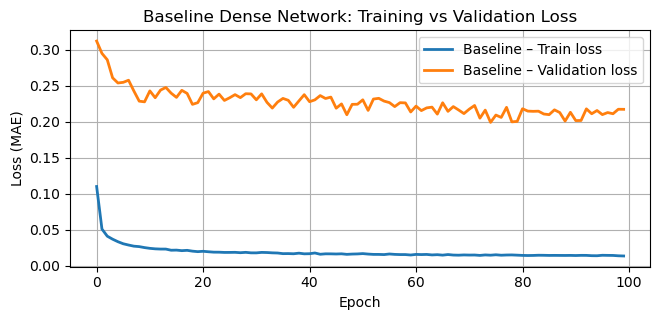

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


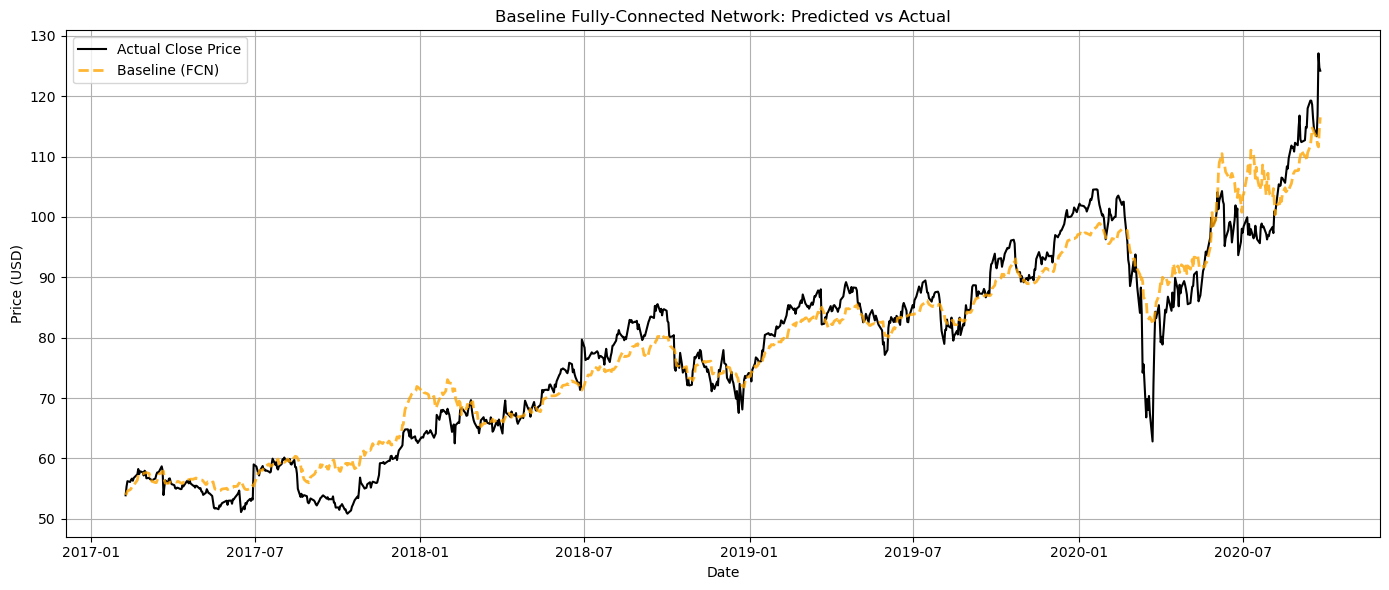


 MAE and R² Score Comparison LSTM network vs. FFN/ Vergleich von MAE und R2 Bestimmtheitsmaß des LSTM Netzwerks vs. FFN:
  LSTM      MAE: 1.0941 USD | R²: 0.9877
  BASELINE  MAE: 3.0713 USD | R²: 0.9386


In [145]:
# === Baseline fully-connected network for comparison / Baseline FNN als Vergleich ===

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Reuse: number_of_delays, scaler, test_trend, y_true from main LSTM script above
# Wiederverwendung: number_of_delays, scaler, test_trend, y_true vom obigen LSTM script

# Ensure window reshaping
# Sicherstellung des reshaping der Fenster
X_train_f = X_train.reshape(-1, number_of_delays)
X_val_f   = X_val.reshape(-1, number_of_delays)
X_test_f  = X_test.reshape(-1, number_of_delays)

# (1) Build baseline model / Baue baseline Modell
baseline = Sequential([
    Flatten(input_shape=(number_of_delays,)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dropout(0),
    Dense(1)
])
baseline.compile(optimizer='adam', loss='mae')
baseline.summary()

# (2) Train baseline model / Trainiere baseline Modell auf den Trainingsdaten
# Standard parameter choice as for the LSTM model / Standardwahl für Parameter zum Vergleich mit dem LSTM Modell
history_base = baseline.fit(
    X_train_f, y_train,
    validation_data=(X_val_f, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# (3) Model evaluation via ploting of training and validation loss / Modellevaluation durch Auftragen des Trainings- und Validationlosses
plt.figure(figsize=(6.7, 3.3))
plt.plot(history_base.history['loss'], label='Baseline – Train loss', linewidth=2)
plt.plot(history_base.history['val_loss'], label='Baseline – Validation loss', linewidth=2)
plt.title("Baseline Dense Network: Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss (MAE)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# (4) Prediction on unseen test data, inverse-transform for the normalization and reapply trend / Vorhersage auf den Testdaten, inverse Transformation zur Normierung und abschließendes Hinzufügen des Trends
y_pred_base = baseline.predict(X_test_f).flatten()
denorm_base = scaler.inverse_transform(y_pred_base.reshape(-1, 1)).flatten()
base_usd = denorm_base + test_trend

# (5) Plot prediction vs actual data / Graphische Darstellung der Vorhersage im Vergleich zu den eigentlichen empirischen Daten
y_true = merged['Close']
plt.figure(figsize=(14, 6))
plt.plot(merged['Date'],y_true, label='Actual Close Price', color='black')  # Optional: pass a date index if available
plt.plot(merged['Date'],base_usd, label='Baseline (FCN)', linestyle='--', linewidth=2, alpha=0.8, color='orange')
plt.title("Baseline Fully-Connected Network: Predicted vs Actual")
plt.xlabel("Date")  # Or "Date" if applicable
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# (6) Metrics MAE and R2 for naive quality control of the fit / Naive Punktmetriken MAE und R2 zur Qualitätskontrolle des fits
mae_base_usd = mean_absolute_error(y_true, base_usd)
r2_base_usd = r2_score(y_true, base_usd)

print("\n MAE and R² Score Comparison LSTM network vs. FFN/ Vergleich von MAE und R2 Bestimmtheitsmaß des LSTM Netzwerks vs. FFN:")
print(f"  LSTM      MAE: {mae_lstm:.4f} USD | R²: {r2_lstm:.4f}")   # from Step 11
print(f"  BASELINE  MAE: {mae_base_usd:.4f} USD | R²: {r2_base_usd:.4f}")

### Results & Conclusion for the FFN

The plain dense network’s error is **larger** and it explains **less variance** than the LSTM. This confirms that **explicit sequence modelling (recurrence)** captures temporal dependencies the dense net cannot, despite identical data and similar parameter count. Hence, for financial time-series the added complexity of an LSTM is justified and delivers markedly superior predictive accuracy over a non-recurrent baseline.

### Ergebnisse & Fazit fürs dichte Netzwerk 

Das dichte Netz hat einen Fehler, der **höher** ist, und es erklärt **weniger Varianz** als das LSTM. Damit wird bestätigt, dass **explizites Sequenzmodellieren (Rekurrenz)** zeitliche Abhängigkeiten erfasst, die das dichte Netz trotz identischer Daten und ähnlicher Parameteranzahl nicht abbilden kann. Für Finanzzeitreihen ist die zusätzliche Komplexität eines LSTM daher gerechtfertigt und liefert eine deutlich überlegene Prognosegenauigkeit gegenüber einem nicht-rekurrenten Baseline-Modell.